In [1]:
import torch
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import os
import seaborn as sns

import sys
sys.path.insert(0,'/home/gsoc0/Adversarial_CapsNet_Pytorch/')
from model.net import *
from model.cnn_net import *
from utils.training import *
from data.data import *

## Experiment Config

In [2]:
model_path = os.path.join(os.getcwd(), "weights")

args = {
    'DATASET_NAME':'mnist',
    'num_classes':10,
    
    'USE_CUDA': True if torch.cuda.is_available() else False,
    'BATCH_SIZE': 32,
#     'N_EPOCHS': 100,
#     'LEARNING_RATE_1': 1e-2,
#     'LEARNING_RATE_2': 1e-2,
#     'WEIGHTDECAY':5e-6,
#     #Scheduler
#     'USE_SCHEDULER':True,
#     'sched_milestones':[14,25,30,40,50],
#     'sched_gamma':0.1,
    
#     #Loss Function
#     'LAMBDA_recon': 0.5,
#     'LAMBDA_class': 1,
    
    ##For Decoder
    'num_features':160,
    'LReLU_negative_slope':0.1,
    'input_height':28,
    'input_width':28,
    'input_channel':1,
    'type':'plusR',
    
}

#Setting Default Cuda Device
torch.cuda.set_device(2)

## Model Loading

In [3]:
def imshow(img):
#     img = img * 0.3081 + 0.1307     # unnormalize
    npimg = img.cpu().numpy()
#     plt.imshow(np.transpose(npimg)#, (1, 2, 0)))
    plt.imshow(npimg)
    plt.show()

In [4]:
class Config:
    def __init__(self, dataset='mnist'):
        # CNN (cnn)
        self.cnn_in_channels = 1
        self.cnn_out_channels = 12
        self.cnn_kernel_size = 15

        # Primary Capsule (pc)
        self.pc_num_capsules = 1
        self.pc_in_channels = 12
        self.pc_out_channels = 16
        self.pc_kernel_size = 8
        self.pc_num_routes = 7 * 7

        # Digit Capsule 1 (dc)
        self.dc_num_capsules = 49
        self.dc_num_routes = 7 * 7
        self.dc_in_channels = 16
        self.dc_out_channels = 16 #1
        
        # Digit Capsule 2 (dc)
        self.dc_2_num_capsules = 10
        self.dc_2_num_routes = 7 * 7
        self.dc_2_in_channels = 16 #1
        self.dc_2_out_channels = 16

        # Decoder
        self.input_width = 28
        self.input_height = 28
torch.manual_seed(1)
config = Config()

net = CapsNet(args, config)
# capsule_net = torch.nn.DataParallel(capsule_net)
if args['USE_CUDA']:
    net = net.cuda()
    
net.load_state_dict(torch.load(os.path.join(model_path, 'CapsNet_mnist.pth'), map_location='cpu'))

<All keys matched successfully>

## Loading Dataset

In [5]:
trainloader, testloader = dataset(args)
for data in trainloader:
    print(data[0][0].min())
    print(data[0][0].max())
    break

tensor(-0.4242)
tensor(2.8215)


## WhiteBox Attack for CapsuleNet

In [6]:
import matplotlib.pyplot as plt
from advertorch.attacks import LinfPGDAttack, GradientSignAttack, CarliniWagnerL2Attack, LinfBasicIterativeAttack

class Model_for_Adversary(nn.Module):
    def __init__(self, net):
        super(Model_for_Adversary, self).__init__()
        self.net = net
        
    def forward(self, x):
        output, recons, masked = self.net(x)
        classes = torch.sqrt((output ** 2).sum(2)).squeeze()
        return classes
    
def WhiteBox_Attacks_Targeted(net, dataloader, adversary_dict, args, theta):
    net.eval()
    n_batch = len(dataloader)
    for adversary in adversary_dict.keys():
        for batch_id, (data, labels) in enumerate(tqdm(dataloader)):
            target = torch.randint(0,10,size=(labels.size(0),), dtype=labels.dtype).cuda()
            if(args['USE_CUDA']):
                data, labels = data.cuda(), labels.cuda()
            adv_data = adversary_dict[adversary].perturb(data, target)
            with torch.no_grad():
                output, reconstructions, max_length_indices = net(adv_data)
                unnormalized_data_adv = net.decoder.unnormalize(adv_data)
                unnormalized_data_clean = net.decoder.unnormalize(data)
                l2_distances = ((reconstructions.view(adv_data.size(0),-1)-unnormalized_data_adv.view(adv_data.size(0), -1))**2).sum(1).squeeze().detach()
                perturbations = unnormalized_data_adv - unnormalized_data_clean 
            for i in range(args['BATCH_SIZE']):
                clean_image = unnormalized_data_clean[i].reshape(28,28).detach().cpu().numpy()
                recon_image = reconstructions[i].reshape(28, 28).detach().cpu().numpy()
                adv_image = unnormalized_data_adv[i].reshape(28,28).detach().cpu().numpy()
                perturb_image = perturbations[i].reshape(28,28).detach().cpu().numpy()
                f, axarr = plt.subplots(1,4)
                axarr[0].imshow(clean_image)
                axarr[1].imshow(perturb_image)
                axarr[2].imshow(adv_image)
                axarr[3].imshow(recon_image)
                plt.show()
                print("L2_distance:", l2_distances[i].item(),"Target: ", target[i].item() , "Model_fooled :", (target[i]==max_length_indices[i]).item(), ": d <= theta", (l2_distances[i]<=theta).item())
            break

def WhiteBox_Attacks_Untargeted(net, dataloader, adversary_dict, args, theta):
    net.eval()
    n_batch = len(dataloader)
    for adversary in adversary_dict.keys():
        print("THE ADVERSARY IS :", adversary)
        for batch_id, (data, labels) in enumerate(tqdm(dataloader)):
            if(args['USE_CUDA']):
                data, labels = data.cuda(), labels.cuda()
            adv_data = adversary_dict[adversary].perturb(data)
            with torch.no_grad():
                output, reconstructions, max_length_indices = net(adv_data)
                unnormalized_data_adv = net.decoder.unnormalize(adv_data)
                unnormalized_data_clean = net.decoder.unnormalize(data)
                l2_distances = ((reconstructions.view(adv_data.size(0),-1)-unnormalized_data_adv.view(adv_data.size(0), -1))**2).sum(1).squeeze().detach()
                perturbations = unnormalized_data_adv - unnormalized_data_clean 
            for i in range(args['BATCH_SIZE']):
                clean_image = unnormalized_data_clean[i].reshape(28,28).detach().cpu().numpy()
                recon_image = reconstructions[i].reshape(28, 28).detach().cpu().numpy()
                adv_image = unnormalized_data_adv[i].reshape(28,28).detach().cpu().numpy()
                perturb_image = perturbations[i].reshape(28,28).detach().cpu().numpy()
                f, axarr = plt.subplots(1,4)
                axarr[0].imshow(clean_image)
                axarr[1].imshow(perturb_image)
                axarr[2].imshow(adv_image)
                axarr[3].imshow(recon_image)
                plt.show()
                print("L2_distance:", l2_distances[i].item(), " Model_fooled :", (labels[i]!=max_length_indices[i]).item(), " d<=theta", (l2_distances[i]<=theta).item())
            break

In [7]:
from advertorch.attacks.base import Attack, LabelMixin
from advertorch.utils import clamp

class CleanAttack(Attack, LabelMixin):
    def __init__(self, clip_min=0., clip_max=1.):
        super(CleanAttack, self).__init__(None,None,clip_min, clip_max)

    def perturb(self, x, y=None):
#         xadv = x.requires_grad_()
#         xadv = clamp(xadv, self.clip_min, self.clip_max)
#         return xadv.detach()
        return x

  0%|          | 0/313 [00:00<?, ?it/s]

THE ADVERSARY IS : Clean


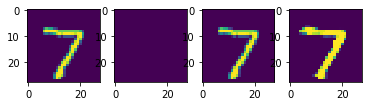

L2_distance: 12.206302642822266  Model_fooled : False  d<=theta True


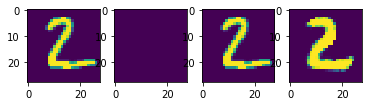

L2_distance: 40.372596740722656  Model_fooled : False  d<=theta True


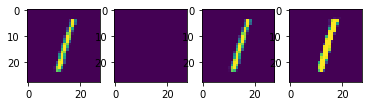

L2_distance: 6.029986381530762  Model_fooled : False  d<=theta True


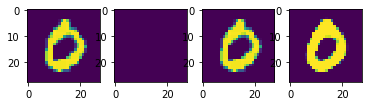

L2_distance: 17.189842224121094  Model_fooled : False  d<=theta True


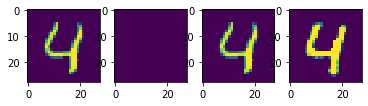

L2_distance: 17.146930694580078  Model_fooled : False  d<=theta True


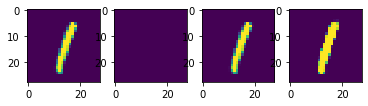

L2_distance: 4.952610969543457  Model_fooled : False  d<=theta True


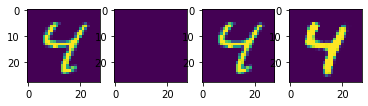

L2_distance: 23.90430450439453  Model_fooled : False  d<=theta True


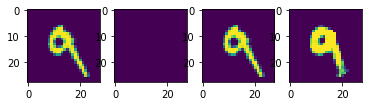

L2_distance: 25.370159149169922  Model_fooled : False  d<=theta True


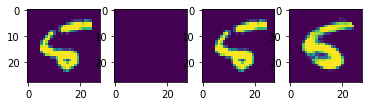

L2_distance: 42.877403259277344  Model_fooled : False  d<=theta True


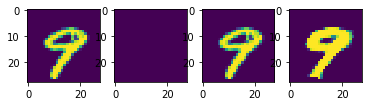

L2_distance: 23.421550750732422  Model_fooled : False  d<=theta True


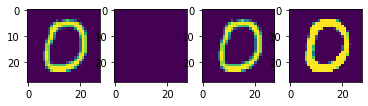

L2_distance: 19.00050926208496  Model_fooled : False  d<=theta True


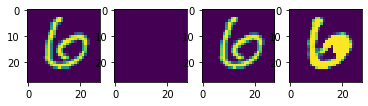

L2_distance: 49.96853256225586  Model_fooled : False  d<=theta False


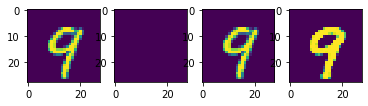

L2_distance: 14.703620910644531  Model_fooled : False  d<=theta True


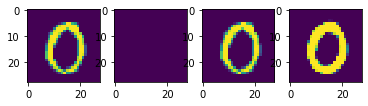

L2_distance: 23.689842224121094  Model_fooled : False  d<=theta True


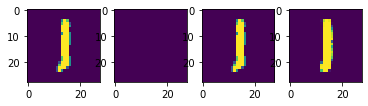

L2_distance: 7.499366283416748  Model_fooled : False  d<=theta True


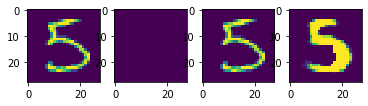

L2_distance: 57.034584045410156  Model_fooled : False  d<=theta False


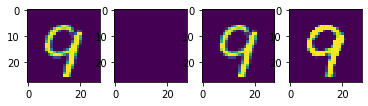

L2_distance: 10.121392250061035  Model_fooled : False  d<=theta True


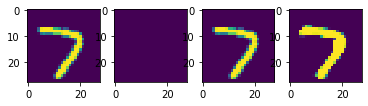

L2_distance: 17.455947875976562  Model_fooled : False  d<=theta True


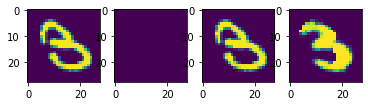

L2_distance: 43.658058166503906  Model_fooled : False  d<=theta True


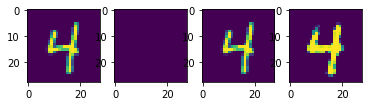

L2_distance: 17.693687438964844  Model_fooled : False  d<=theta True


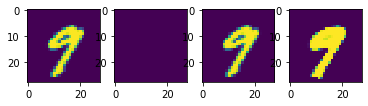

L2_distance: 15.801291465759277  Model_fooled : False  d<=theta True


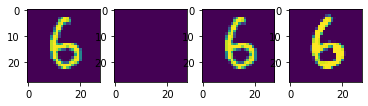

L2_distance: 11.311417579650879  Model_fooled : False  d<=theta True


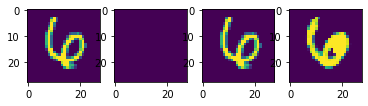

L2_distance: 33.48011779785156  Model_fooled : False  d<=theta True


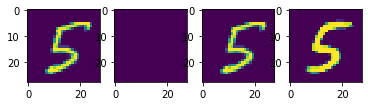

L2_distance: 18.74260139465332  Model_fooled : False  d<=theta True


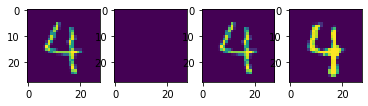

L2_distance: 22.52301025390625  Model_fooled : False  d<=theta True


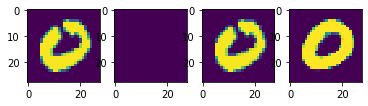

L2_distance: 28.240459442138672  Model_fooled : False  d<=theta True


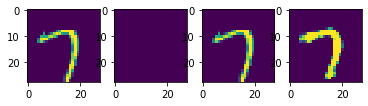

L2_distance: 18.442550659179688  Model_fooled : False  d<=theta True


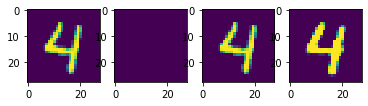

L2_distance: 15.708576202392578  Model_fooled : False  d<=theta True


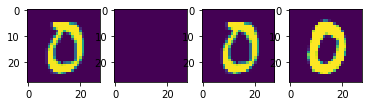

L2_distance: 24.356700897216797  Model_fooled : False  d<=theta True


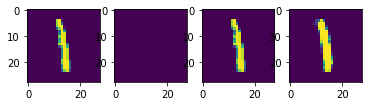

L2_distance: 6.223313331604004  Model_fooled : False  d<=theta True


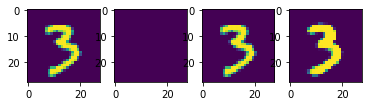

L2_distance: 12.701783180236816  Model_fooled : False  d<=theta True


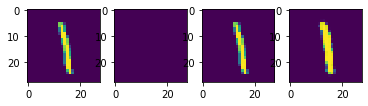


  0%|          | 0/313 [00:00<?, ?it/s]

L2_distance: 5.669441223144531  Model_fooled : False  d<=theta True
THE ADVERSARY IS : PGD


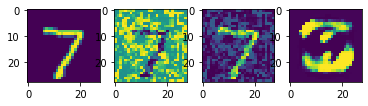

L2_distance: 138.81976318359375  Model_fooled : True  d<=theta False


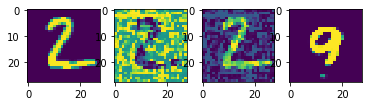

L2_distance: 142.9412841796875  Model_fooled : True  d<=theta False


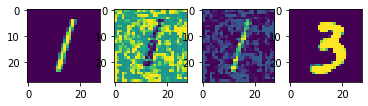

L2_distance: 101.50125122070312  Model_fooled : True  d<=theta False


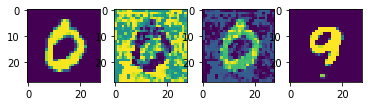

L2_distance: 109.68145751953125  Model_fooled : True  d<=theta False


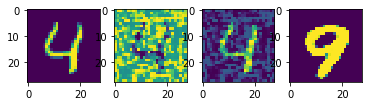

L2_distance: 106.33613586425781  Model_fooled : True  d<=theta False


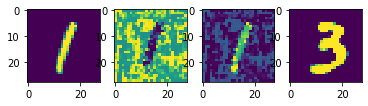

L2_distance: 98.37116241455078  Model_fooled : True  d<=theta False


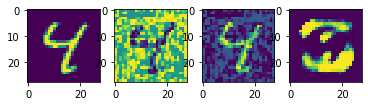

L2_distance: 134.46072387695312  Model_fooled : True  d<=theta False


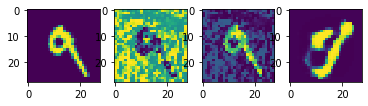

L2_distance: 105.74397277832031  Model_fooled : True  d<=theta False


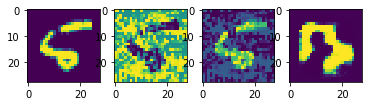

L2_distance: 129.3827362060547  Model_fooled : True  d<=theta False


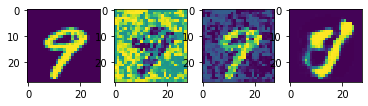

L2_distance: 83.49186706542969  Model_fooled : True  d<=theta False


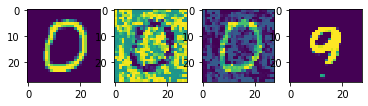

L2_distance: 136.0684814453125  Model_fooled : True  d<=theta False


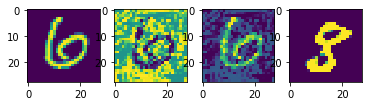

L2_distance: 117.8642578125  Model_fooled : True  d<=theta False


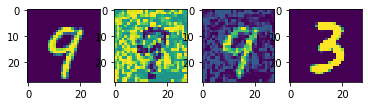

L2_distance: 109.98941802978516  Model_fooled : True  d<=theta False


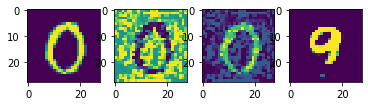

L2_distance: 108.04780578613281  Model_fooled : True  d<=theta False


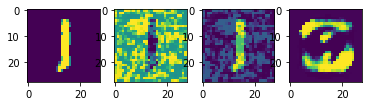

L2_distance: 110.72040557861328  Model_fooled : True  d<=theta False


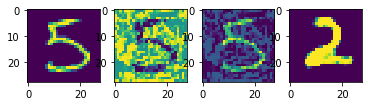

L2_distance: 132.80209350585938  Model_fooled : True  d<=theta False


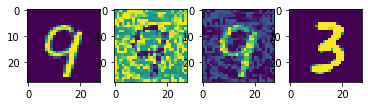

L2_distance: 110.40162658691406  Model_fooled : True  d<=theta False


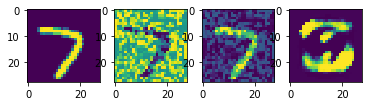

L2_distance: 130.8184356689453  Model_fooled : True  d<=theta False


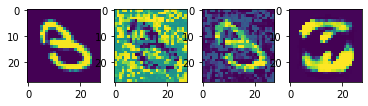

L2_distance: 112.04167175292969  Model_fooled : True  d<=theta False


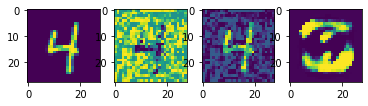

L2_distance: 151.6649169921875  Model_fooled : True  d<=theta False


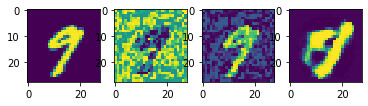

L2_distance: 82.4252700805664  Model_fooled : True  d<=theta False


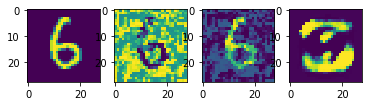

L2_distance: 139.39959716796875  Model_fooled : True  d<=theta False


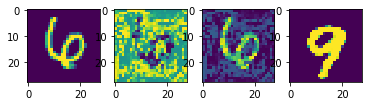

L2_distance: 99.259765625  Model_fooled : True  d<=theta False


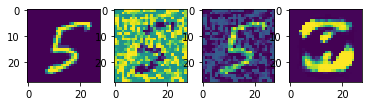

L2_distance: 139.31666564941406  Model_fooled : True  d<=theta False


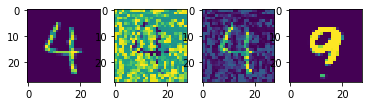

L2_distance: 73.53495788574219  Model_fooled : True  d<=theta False


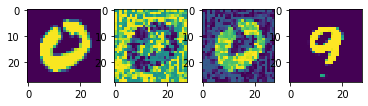

L2_distance: 156.10179138183594  Model_fooled : True  d<=theta False


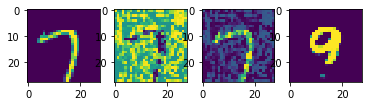

L2_distance: 85.09588623046875  Model_fooled : True  d<=theta False


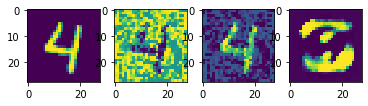

L2_distance: 155.08978271484375  Model_fooled : True  d<=theta False


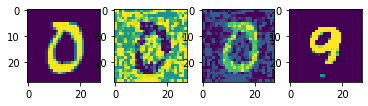

L2_distance: 123.87738037109375  Model_fooled : True  d<=theta False


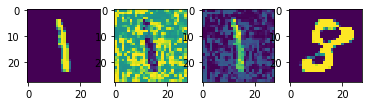

L2_distance: 117.67601776123047  Model_fooled : True  d<=theta False


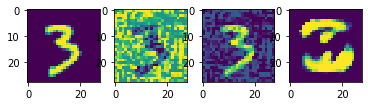

L2_distance: 141.75653076171875  Model_fooled : True  d<=theta False


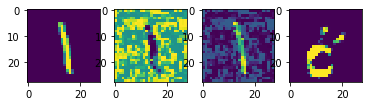



  0%|          | 0/313 [00:00<?, ?it/s]

L2_distance: 77.61412048339844  Model_fooled : True  d<=theta False
THE ADVERSARY IS : FGSM


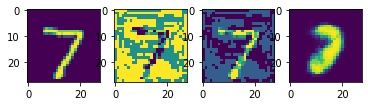

L2_distance: 86.30950927734375  Model_fooled : True  d<=theta False


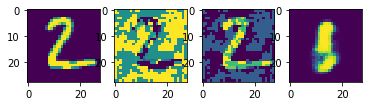

L2_distance: 98.27394104003906  Model_fooled : True  d<=theta False


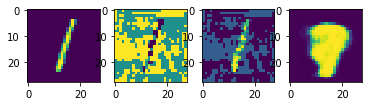

L2_distance: 132.7601318359375  Model_fooled : False  d<=theta False


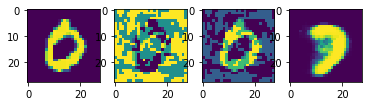

L2_distance: 98.00079345703125  Model_fooled : True  d<=theta False


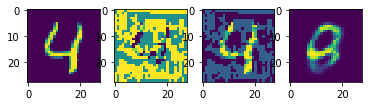

L2_distance: 68.05191040039062  Model_fooled : True  d<=theta False


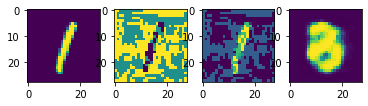

L2_distance: 104.53025817871094  Model_fooled : True  d<=theta False


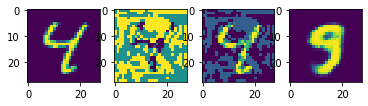

L2_distance: 97.009033203125  Model_fooled : True  d<=theta False


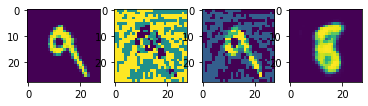

L2_distance: 90.88349914550781  Model_fooled : True  d<=theta False


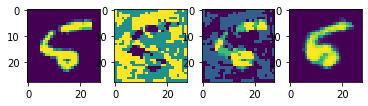

L2_distance: 64.87153625488281  Model_fooled : True  d<=theta False


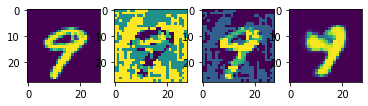

L2_distance: 64.84729766845703  Model_fooled : True  d<=theta False


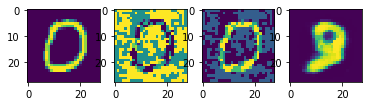

L2_distance: 123.79290008544922  Model_fooled : True  d<=theta False


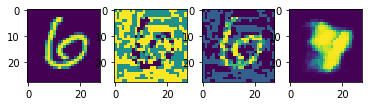

L2_distance: 105.54305267333984  Model_fooled : True  d<=theta False


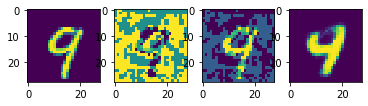

L2_distance: 57.507022857666016  Model_fooled : True  d<=theta False


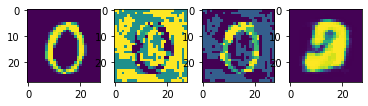

L2_distance: 112.68769073486328  Model_fooled : True  d<=theta False


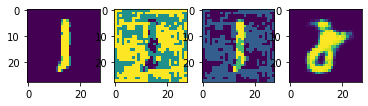

L2_distance: 79.08112335205078  Model_fooled : True  d<=theta False


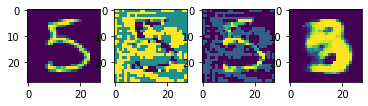

L2_distance: 121.25749969482422  Model_fooled : True  d<=theta False


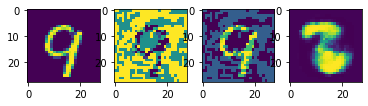

L2_distance: 113.08495330810547  Model_fooled : False  d<=theta False


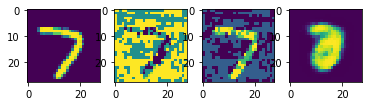

L2_distance: 99.37065887451172  Model_fooled : True  d<=theta False


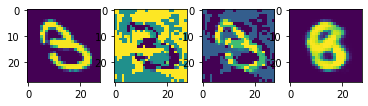

L2_distance: 110.03633117675781  Model_fooled : True  d<=theta False


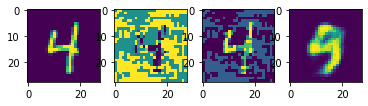

L2_distance: 72.5503921508789  Model_fooled : True  d<=theta False


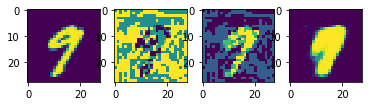

L2_distance: 69.66133117675781  Model_fooled : True  d<=theta False


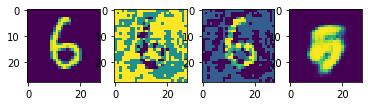

L2_distance: 96.95094299316406  Model_fooled : True  d<=theta False


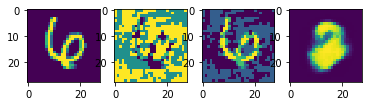

L2_distance: 100.82197570800781  Model_fooled : True  d<=theta False


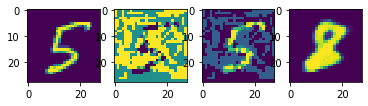

L2_distance: 90.07332611083984  Model_fooled : True  d<=theta False


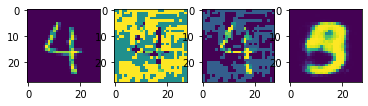

L2_distance: 121.38444519042969  Model_fooled : True  d<=theta False


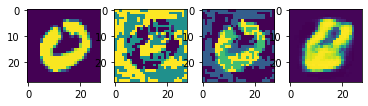

L2_distance: 84.87185668945312  Model_fooled : True  d<=theta False


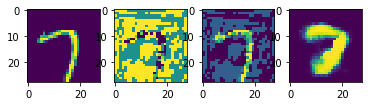

L2_distance: 99.56168365478516  Model_fooled : True  d<=theta False


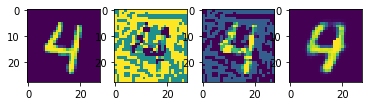

L2_distance: 59.540443420410156  Model_fooled : False  d<=theta False


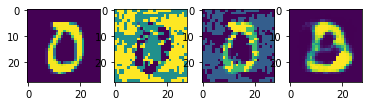

L2_distance: 59.3188591003418  Model_fooled : False  d<=theta False


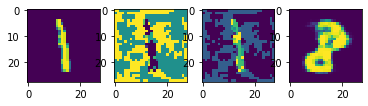

L2_distance: 90.92985534667969  Model_fooled : True  d<=theta False


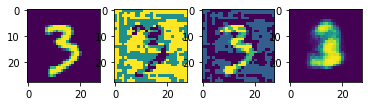

L2_distance: 82.3623275756836  Model_fooled : True  d<=theta False


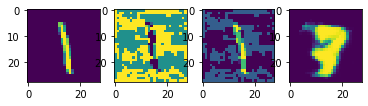




  0%|          | 0/313 [00:00<?, ?it/s]

L2_distance: 93.75160217285156  Model_fooled : True  d<=theta False
THE ADVERSARY IS : BIM


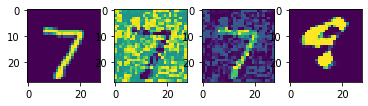

L2_distance: 114.8779296875  Model_fooled : True  d<=theta False


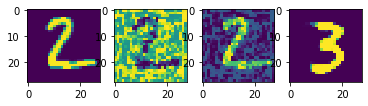

L2_distance: 115.06878662109375  Model_fooled : True  d<=theta False


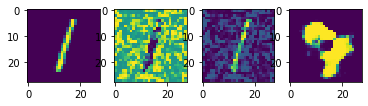

L2_distance: 145.40814208984375  Model_fooled : True  d<=theta False


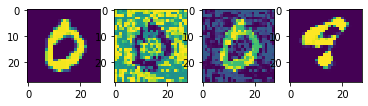

L2_distance: 130.70620727539062  Model_fooled : True  d<=theta False


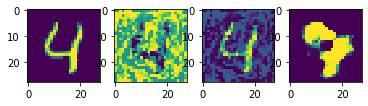

L2_distance: 117.04547119140625  Model_fooled : True  d<=theta False


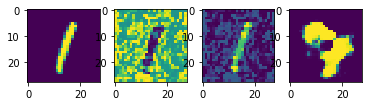

L2_distance: 143.85220336914062  Model_fooled : True  d<=theta False


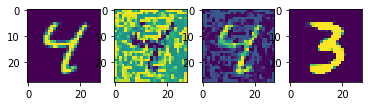

L2_distance: 110.07060241699219  Model_fooled : True  d<=theta False


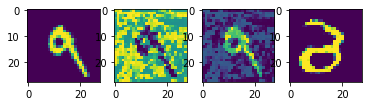

L2_distance: 105.92758178710938  Model_fooled : True  d<=theta False


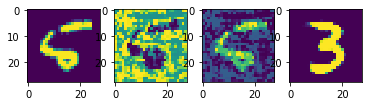

L2_distance: 133.677734375  Model_fooled : True  d<=theta False


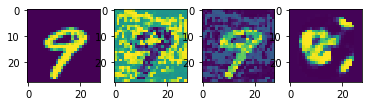

L2_distance: 104.95951843261719  Model_fooled : True  d<=theta False


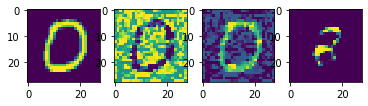

L2_distance: 106.58232879638672  Model_fooled : True  d<=theta False


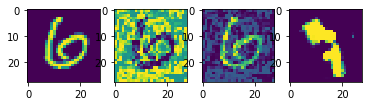

L2_distance: 126.05755615234375  Model_fooled : True  d<=theta False


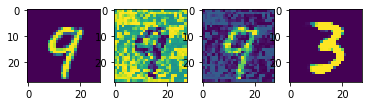

L2_distance: 112.89608764648438  Model_fooled : True  d<=theta False


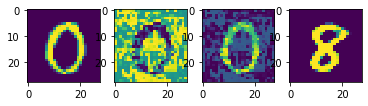

L2_distance: 109.62309265136719  Model_fooled : True  d<=theta False


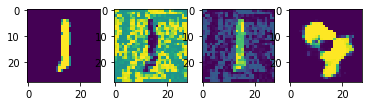

L2_distance: 126.48808288574219  Model_fooled : True  d<=theta False


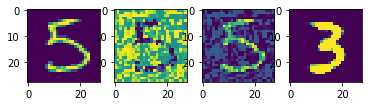

L2_distance: 111.63481140136719  Model_fooled : True  d<=theta False


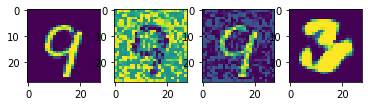

L2_distance: 161.41098022460938  Model_fooled : True  d<=theta False


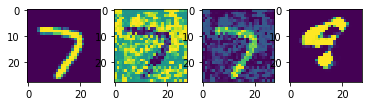

L2_distance: 126.14232635498047  Model_fooled : True  d<=theta False


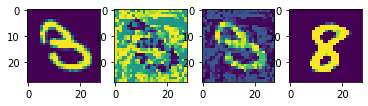

L2_distance: 143.6044464111328  Model_fooled : True  d<=theta False


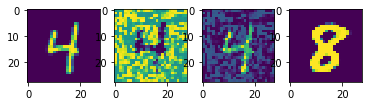

L2_distance: 103.53766632080078  Model_fooled : True  d<=theta False


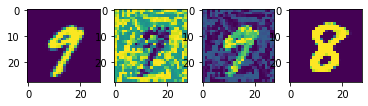

L2_distance: 111.91212463378906  Model_fooled : True  d<=theta False


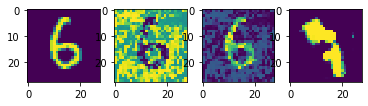

L2_distance: 115.6849365234375  Model_fooled : True  d<=theta False


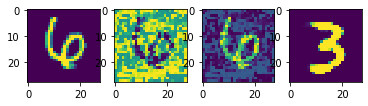

L2_distance: 113.25927734375  Model_fooled : True  d<=theta False


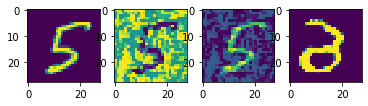

L2_distance: 101.67927551269531  Model_fooled : True  d<=theta False


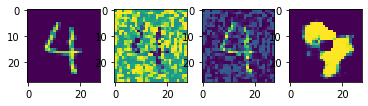

L2_distance: 126.3240737915039  Model_fooled : True  d<=theta False


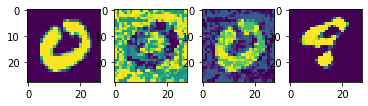

L2_distance: 129.43299865722656  Model_fooled : True  d<=theta False


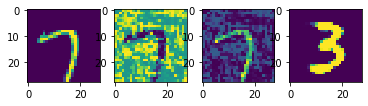

L2_distance: 101.87149047851562  Model_fooled : True  d<=theta False


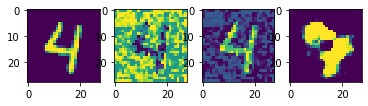

L2_distance: 123.6976547241211  Model_fooled : True  d<=theta False


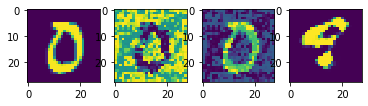

L2_distance: 139.61061096191406  Model_fooled : True  d<=theta False


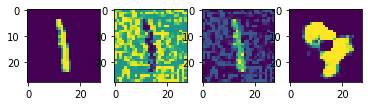

L2_distance: 122.29361724853516  Model_fooled : True  d<=theta False


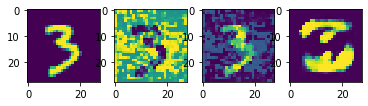

L2_distance: 125.64213562011719  Model_fooled : True  d<=theta False


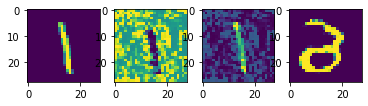

L2_distance: 106.86355590820312  Model_fooled : True  d<=theta False


In [8]:
model_for_adversary = Model_for_Adversary(net)

linf_eps = 0.3
fgsm_step = 0.05
bim_pgd_step = 0.01

adversary_dict = {}
adversary_dict['Clean'] = CleanAttack(clip_min=-0.4242, clip_max=2.8215)
adversary_dict['PGD'] = LinfPGDAttack(
    model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(linf_eps/0.3081),
    nb_iter=1000, eps_iter=(bim_pgd_step/0.3081), rand_init=True, clip_min=-0.4242, clip_max=2.8215,
    targeted=False)

adversary_dict['FGSM'] = GradientSignAttack(model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(linf_eps/0.3081), clip_min=-0.4242, clip_max=2.8215, targeted=False)
adversary_dict['BIM'] = LinfBasicIterativeAttack(model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(linf_eps/0.3081), nb_iter=1000, eps_iter=(bim_pgd_step/0.3081), clip_min=-0.4242, clip_max=2.8215, targeted=False)
# adversary_dict['CW'] = CarliniWagnerL2Attack(model_for_adversary, num_classes=args['num_classes'], confidence=0, targeted=False, learning_rate=0.01, binary_search_steps=9, max_iterations=1000, abort_early=True, initial_const=0.001, clip_min=-0.4242, clip_max=2.8215, loss_fn=None)

WhiteBox_Attacks_Untargeted(net, testloader, adversary_dict, args, 44)





  0%|          | 0/313 [00:00<?, ?it/s]

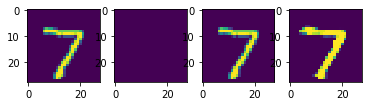

L2_distance: 12.206302642822266 Target:  6 Model_fooled : False : d <= theta True


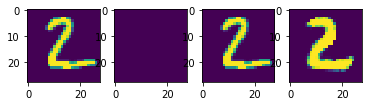

L2_distance: 40.372596740722656 Target:  8 Model_fooled : False : d <= theta True


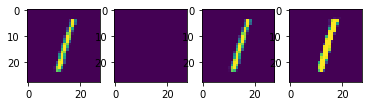

L2_distance: 6.029986381530762 Target:  9 Model_fooled : False : d <= theta True


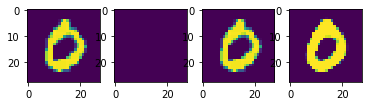

L2_distance: 17.189842224121094 Target:  7 Model_fooled : False : d <= theta True


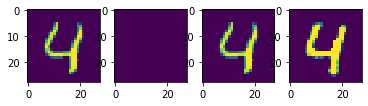

L2_distance: 17.146930694580078 Target:  2 Model_fooled : False : d <= theta True


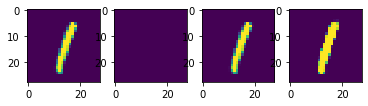

L2_distance: 4.952610969543457 Target:  9 Model_fooled : False : d <= theta True


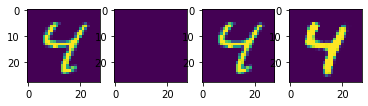

L2_distance: 23.90430450439453 Target:  3 Model_fooled : False : d <= theta True


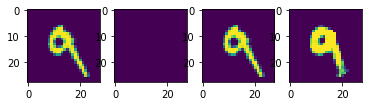

L2_distance: 25.370159149169922 Target:  7 Model_fooled : False : d <= theta True


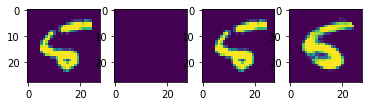

L2_distance: 42.877403259277344 Target:  4 Model_fooled : False : d <= theta True


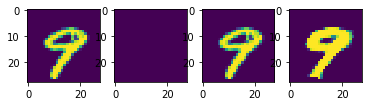

L2_distance: 23.421550750732422 Target:  5 Model_fooled : False : d <= theta True


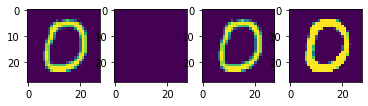

L2_distance: 19.00050926208496 Target:  5 Model_fooled : False : d <= theta True


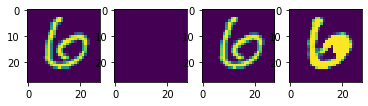

L2_distance: 49.96853256225586 Target:  6 Model_fooled : True : d <= theta False


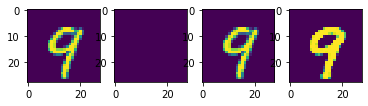

L2_distance: 14.703620910644531 Target:  3 Model_fooled : False : d <= theta True


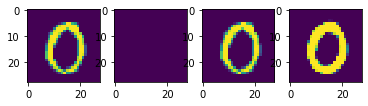

L2_distance: 23.689842224121094 Target:  3 Model_fooled : False : d <= theta True


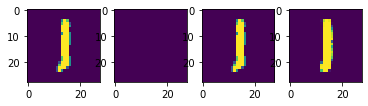

L2_distance: 7.499366283416748 Target:  0 Model_fooled : False : d <= theta True


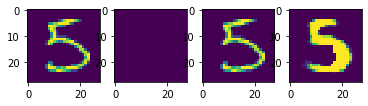

L2_distance: 57.034584045410156 Target:  8 Model_fooled : False : d <= theta False


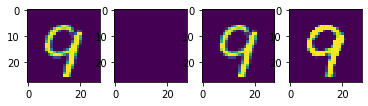

L2_distance: 10.121392250061035 Target:  1 Model_fooled : False : d <= theta True


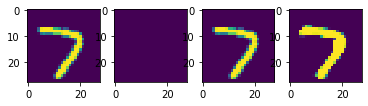

L2_distance: 17.455947875976562 Target:  8 Model_fooled : False : d <= theta True


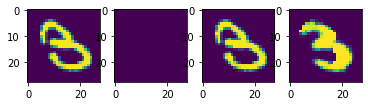

L2_distance: 43.658058166503906 Target:  1 Model_fooled : False : d <= theta True


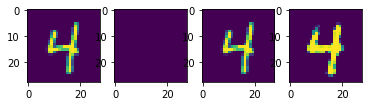

L2_distance: 17.693687438964844 Target:  7 Model_fooled : False : d <= theta True


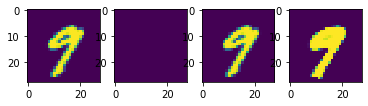

L2_distance: 15.801291465759277 Target:  6 Model_fooled : False : d <= theta True


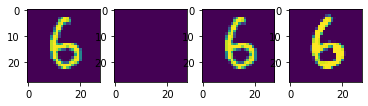

L2_distance: 11.311417579650879 Target:  1 Model_fooled : False : d <= theta True


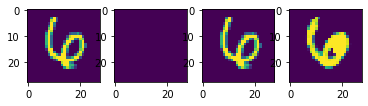

L2_distance: 33.48011779785156 Target:  3 Model_fooled : False : d <= theta True


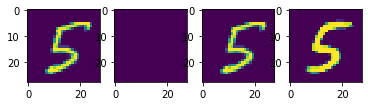

L2_distance: 18.74260139465332 Target:  1 Model_fooled : False : d <= theta True


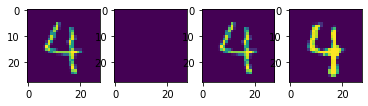

L2_distance: 22.52301025390625 Target:  1 Model_fooled : False : d <= theta True


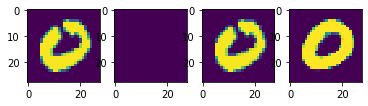

L2_distance: 28.240459442138672 Target:  9 Model_fooled : False : d <= theta True


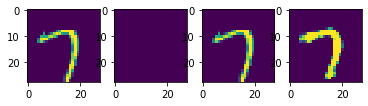

L2_distance: 18.442550659179688 Target:  3 Model_fooled : False : d <= theta True


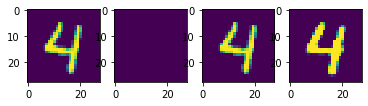

L2_distance: 15.708576202392578 Target:  0 Model_fooled : False : d <= theta True


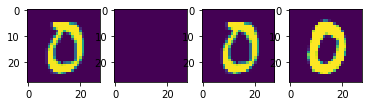

L2_distance: 24.356700897216797 Target:  8 Model_fooled : False : d <= theta True


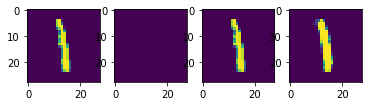

L2_distance: 6.223313331604004 Target:  5 Model_fooled : False : d <= theta True


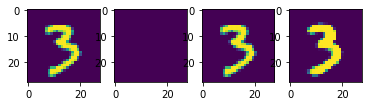

L2_distance: 12.701783180236816 Target:  8 Model_fooled : False : d <= theta True


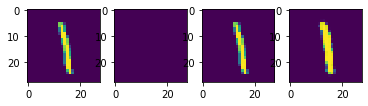






  0%|          | 0/313 [00:00<?, ?it/s]

L2_distance: 5.669441223144531 Target:  1 Model_fooled : True : d <= theta True


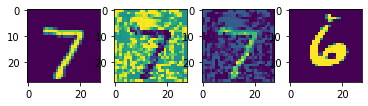

L2_distance: 110.35731506347656 Target:  6 Model_fooled : True : d <= theta False


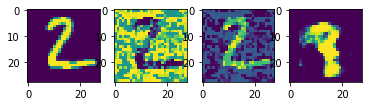

L2_distance: 112.54985046386719 Target:  0 Model_fooled : True : d <= theta False


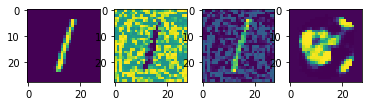

L2_distance: 108.99349212646484 Target:  3 Model_fooled : True : d <= theta False


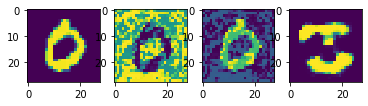

L2_distance: 139.41009521484375 Target:  4 Model_fooled : True : d <= theta False


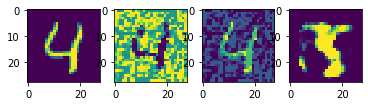

L2_distance: 113.9693603515625 Target:  0 Model_fooled : True : d <= theta False


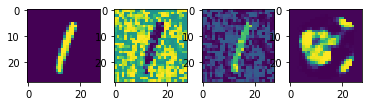

L2_distance: 98.14390563964844 Target:  3 Model_fooled : True : d <= theta False


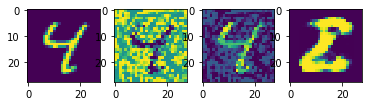

L2_distance: 149.81036376953125 Target:  7 Model_fooled : True : d <= theta False


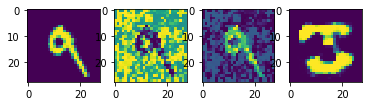

L2_distance: 140.39346313476562 Target:  4 Model_fooled : True : d <= theta False


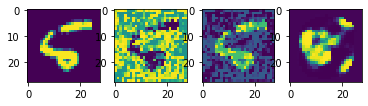

L2_distance: 95.52861785888672 Target:  3 Model_fooled : True : d <= theta False


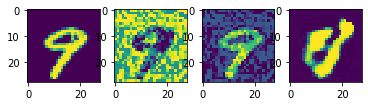

L2_distance: 90.88626098632812 Target:  2 Model_fooled : True : d <= theta False


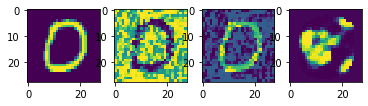

L2_distance: 133.24072265625 Target:  3 Model_fooled : True : d <= theta False


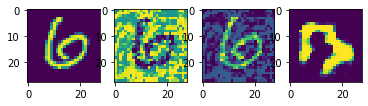

L2_distance: 139.15505981445312 Target:  8 Model_fooled : True : d <= theta False


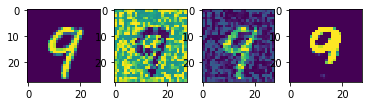

L2_distance: 59.89287185668945 Target:  9 Model_fooled : True : d <= theta False


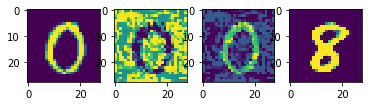

L2_distance: 106.19415283203125 Target:  8 Model_fooled : True : d <= theta False


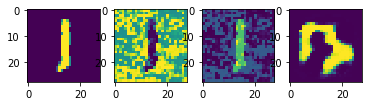

L2_distance: 129.1390838623047 Target:  8 Model_fooled : True : d <= theta False


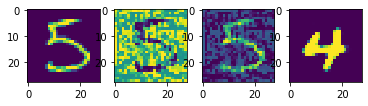

L2_distance: 106.4116439819336 Target:  4 Model_fooled : True : d <= theta False


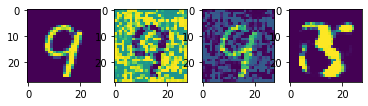

L2_distance: 116.72900390625 Target:  0 Model_fooled : True : d <= theta False


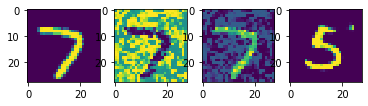

L2_distance: 86.36687469482422 Target:  5 Model_fooled : True : d <= theta False


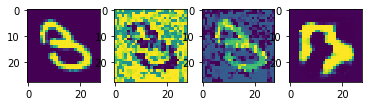

L2_distance: 110.78258514404297 Target:  8 Model_fooled : True : d <= theta False


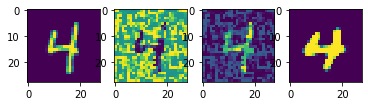

L2_distance: 63.19660186767578 Target:  4 Model_fooled : True : d <= theta False


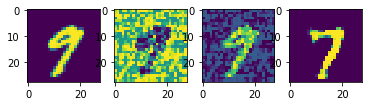

L2_distance: 72.04299926757812 Target:  7 Model_fooled : True : d <= theta False


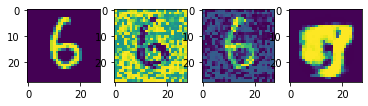

L2_distance: 162.56948852539062 Target:  1 Model_fooled : True : d <= theta False


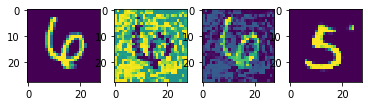

L2_distance: 108.34660339355469 Target:  5 Model_fooled : True : d <= theta False


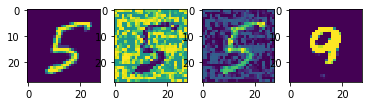

L2_distance: 84.24325561523438 Target:  9 Model_fooled : True : d <= theta False


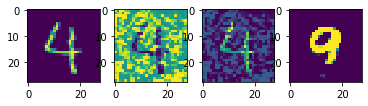

L2_distance: 72.15802001953125 Target:  9 Model_fooled : True : d <= theta False


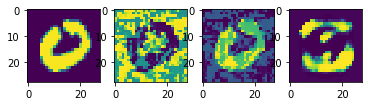

L2_distance: 126.25123596191406 Target:  9 Model_fooled : True : d <= theta False


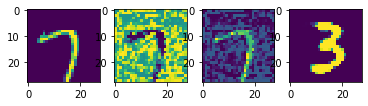

L2_distance: 100.94590759277344 Target:  3 Model_fooled : True : d <= theta False


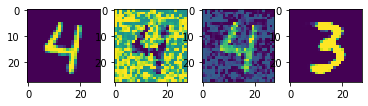

L2_distance: 106.00642395019531 Target:  3 Model_fooled : True : d <= theta False


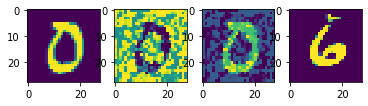

L2_distance: 109.36727905273438 Target:  6 Model_fooled : True : d <= theta False


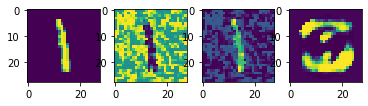

L2_distance: 120.20153045654297 Target:  9 Model_fooled : True : d <= theta False


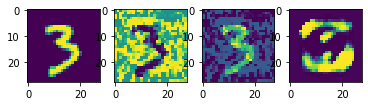

L2_distance: 116.32574462890625 Target:  9 Model_fooled : True : d <= theta False


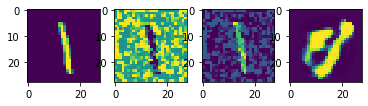







  0%|          | 0/313 [00:00<?, ?it/s]

L2_distance: 111.70762634277344 Target:  2 Model_fooled : True : d <= theta False


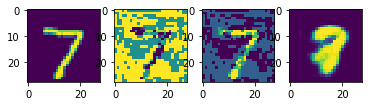

L2_distance: 96.96649169921875 Target:  3 Model_fooled : True : d <= theta False


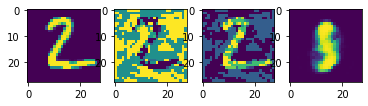

L2_distance: 103.87648010253906 Target:  8 Model_fooled : False : d <= theta False


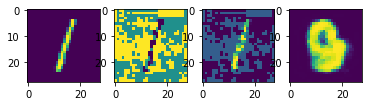

L2_distance: 111.33126831054688 Target:  8 Model_fooled : True : d <= theta False


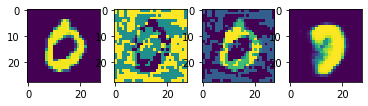

L2_distance: 97.2286376953125 Target:  2 Model_fooled : False : d <= theta False


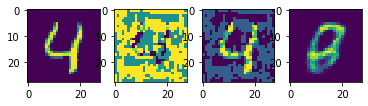

L2_distance: 73.67677307128906 Target:  7 Model_fooled : False : d <= theta False


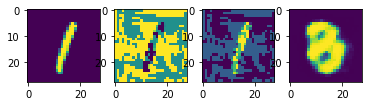

L2_distance: 114.57971954345703 Target:  7 Model_fooled : False : d <= theta False


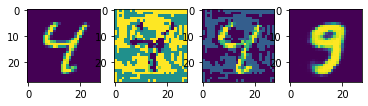

L2_distance: 99.74406433105469 Target:  2 Model_fooled : False : d <= theta False


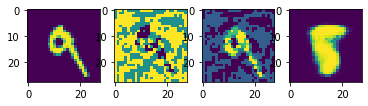

L2_distance: 105.17210388183594 Target:  4 Model_fooled : False : d <= theta False


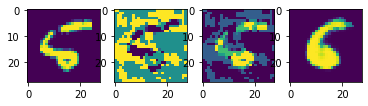

L2_distance: 69.54719543457031 Target:  6 Model_fooled : True : d <= theta False


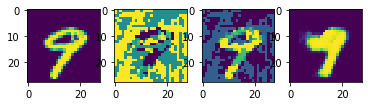

L2_distance: 80.0619125366211 Target:  7 Model_fooled : False : d <= theta False


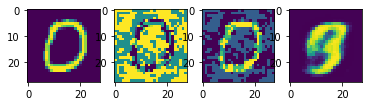

L2_distance: 96.67745971679688 Target:  2 Model_fooled : False : d <= theta False


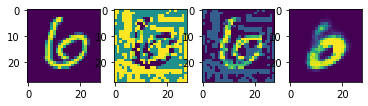

L2_distance: 86.5788345336914 Target:  5 Model_fooled : False : d <= theta False


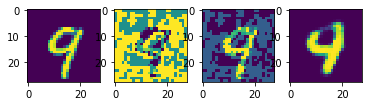

L2_distance: 64.35629272460938 Target:  1 Model_fooled : False : d <= theta False


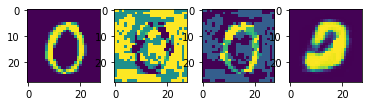

L2_distance: 105.24687957763672 Target:  9 Model_fooled : True : d <= theta False


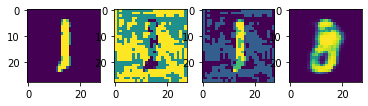

L2_distance: 75.11627197265625 Target:  9 Model_fooled : False : d <= theta False


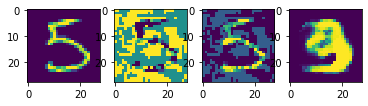

L2_distance: 115.75627899169922 Target:  2 Model_fooled : False : d <= theta False


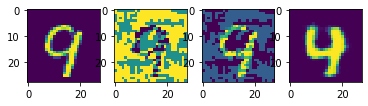

L2_distance: 73.808349609375 Target:  5 Model_fooled : False : d <= theta False


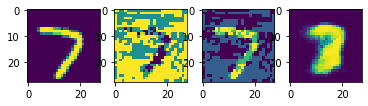

L2_distance: 90.68573760986328 Target:  3 Model_fooled : False : d <= theta False


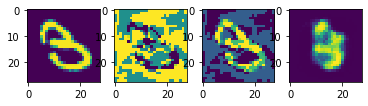

L2_distance: 112.85649108886719 Target:  0 Model_fooled : False : d <= theta False


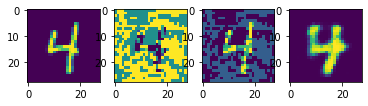

L2_distance: 64.28543090820312 Target:  3 Model_fooled : False : d <= theta False


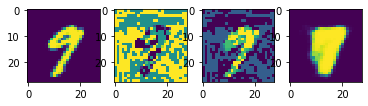

L2_distance: 74.89060974121094 Target:  8 Model_fooled : False : d <= theta False


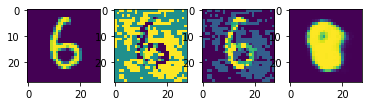

L2_distance: 105.75468444824219 Target:  6 Model_fooled : False : d <= theta False


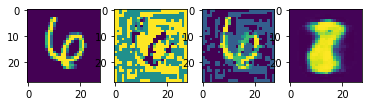

L2_distance: 113.1197738647461 Target:  3 Model_fooled : True : d <= theta False


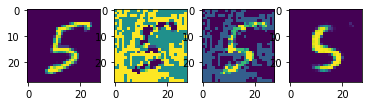

L2_distance: 63.13848876953125 Target:  5 Model_fooled : True : d <= theta False


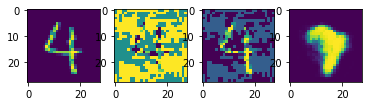

L2_distance: 99.34845733642578 Target:  1 Model_fooled : False : d <= theta False


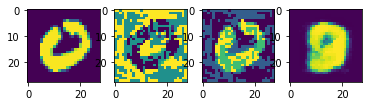

L2_distance: 88.9789047241211 Target:  8 Model_fooled : False : d <= theta False


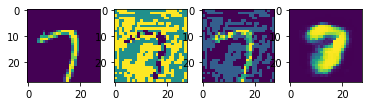

L2_distance: 94.5174789428711 Target:  1 Model_fooled : False : d <= theta False


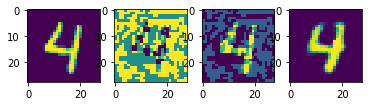

L2_distance: 58.161216735839844 Target:  0 Model_fooled : False : d <= theta False


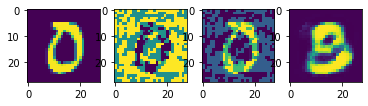

L2_distance: 74.27286529541016 Target:  5 Model_fooled : False : d <= theta False


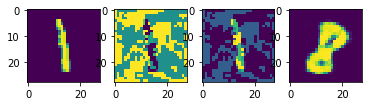

L2_distance: 89.1626968383789 Target:  5 Model_fooled : False : d <= theta False


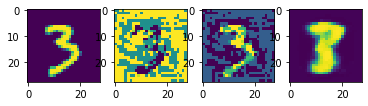

L2_distance: 106.32627868652344 Target:  9 Model_fooled : False : d <= theta False


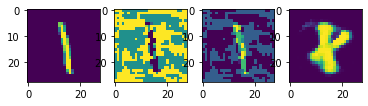








  0%|          | 0/313 [00:00<?, ?it/s]

L2_distance: 79.02276611328125 Target:  9 Model_fooled : False : d <= theta False


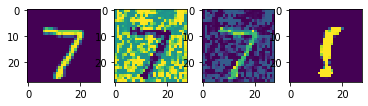

L2_distance: 80.78349304199219 Target:  1 Model_fooled : True : d <= theta False


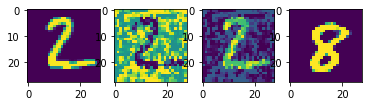

L2_distance: 117.4635009765625 Target:  8 Model_fooled : True : d <= theta False


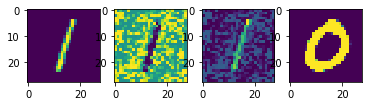

L2_distance: 135.11370849609375 Target:  0 Model_fooled : True : d <= theta False


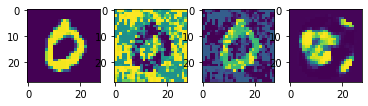

L2_distance: 128.62713623046875 Target:  3 Model_fooled : True : d <= theta False


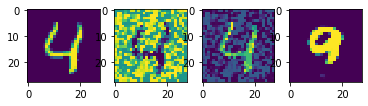

L2_distance: 88.40859985351562 Target:  9 Model_fooled : True : d <= theta False


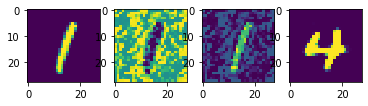

L2_distance: 98.79186248779297 Target:  4 Model_fooled : True : d <= theta False


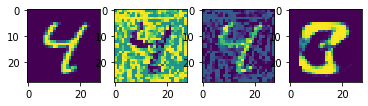

L2_distance: 101.83080291748047 Target:  6 Model_fooled : True : d <= theta False


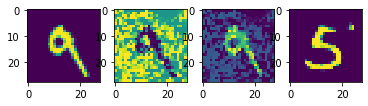

L2_distance: 74.8450927734375 Target:  5 Model_fooled : True : d <= theta False


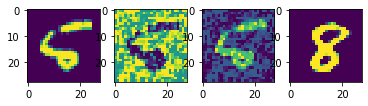

L2_distance: 108.57017517089844 Target:  8 Model_fooled : True : d <= theta False


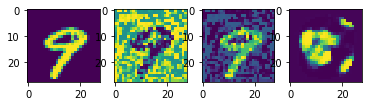

L2_distance: 107.3211898803711 Target:  3 Model_fooled : True : d <= theta False


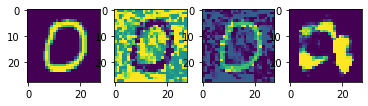

L2_distance: 134.93896484375 Target:  1 Model_fooled : True : d <= theta False


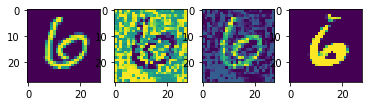

L2_distance: 112.2303466796875 Target:  6 Model_fooled : True : d <= theta False


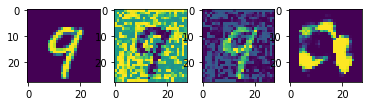

L2_distance: 144.02212524414062 Target:  1 Model_fooled : True : d <= theta False


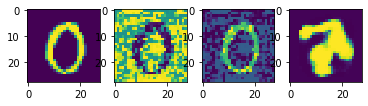

L2_distance: 138.5721435546875 Target:  5 Model_fooled : True : d <= theta False


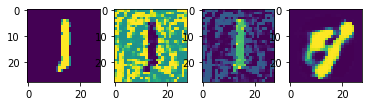

L2_distance: 115.52581787109375 Target:  2 Model_fooled : True : d <= theta False


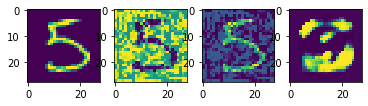

L2_distance: 121.58489990234375 Target:  9 Model_fooled : True : d <= theta False


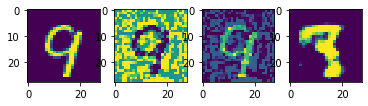

L2_distance: 104.60069274902344 Target:  0 Model_fooled : True : d <= theta False


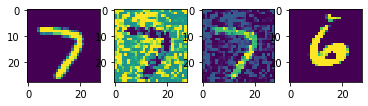

L2_distance: 115.52726745605469 Target:  6 Model_fooled : True : d <= theta False


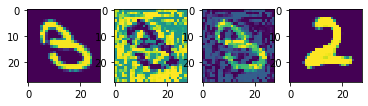

L2_distance: 154.51925659179688 Target:  2 Model_fooled : True : d <= theta False


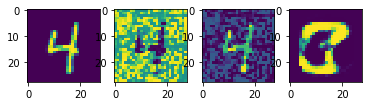

L2_distance: 127.38966369628906 Target:  6 Model_fooled : True : d <= theta False


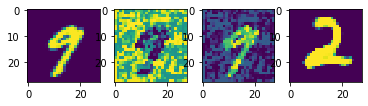

L2_distance: 131.08013916015625 Target:  2 Model_fooled : True : d <= theta False


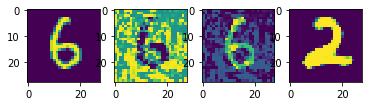

L2_distance: 117.5020751953125 Target:  2 Model_fooled : True : d <= theta False


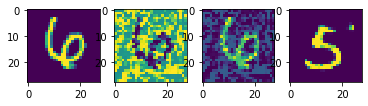

L2_distance: 108.04817199707031 Target:  5 Model_fooled : True : d <= theta False


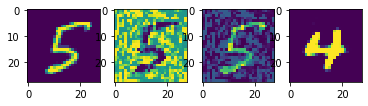

L2_distance: 91.33273315429688 Target:  4 Model_fooled : True : d <= theta False


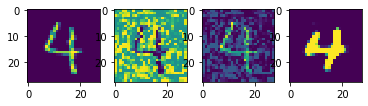

L2_distance: 73.25817108154297 Target:  4 Model_fooled : True : d <= theta False


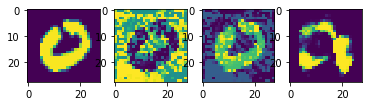

L2_distance: 142.10983276367188 Target:  1 Model_fooled : True : d <= theta False


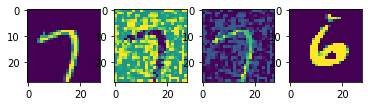

L2_distance: 108.76285552978516 Target:  6 Model_fooled : True : d <= theta False


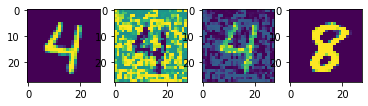

L2_distance: 98.51878356933594 Target:  8 Model_fooled : True : d <= theta False


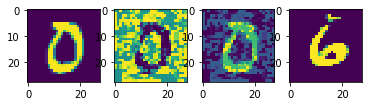

L2_distance: 109.18072509765625 Target:  6 Model_fooled : True : d <= theta False


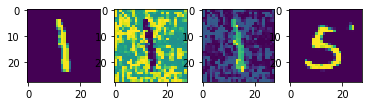

L2_distance: 74.15480041503906 Target:  5 Model_fooled : True : d <= theta False


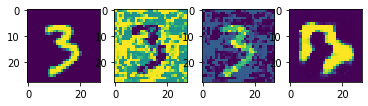

L2_distance: 111.72306823730469 Target:  8 Model_fooled : True : d <= theta False


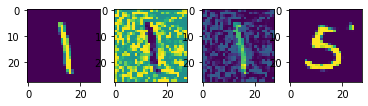

L2_distance: 73.58609771728516 Target:  5 Model_fooled : True : d <= theta False


In [9]:
model_for_adversary = Model_for_Adversary(net)

linf_eps = 0.3
fgsm_step = 0.05
bim_pgd_step = 0.01

adversary_dict = {}
adversary_dict['Clean'] = CleanAttack(clip_min=-0.4242, clip_max=2.8215)
adversary_dict['PGD'] = LinfPGDAttack(
    model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(linf_eps/0.3081),
    nb_iter=1000, eps_iter=(bim_pgd_step/0.3081), rand_init=True, clip_min=-0.4242, clip_max=2.8215,
    targeted=True)

adversary_dict['FGSM'] = GradientSignAttack(model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(linf_eps/0.3081), clip_min=-0.4242, clip_max=2.8215, targeted=True)
adversary_dict['BIM'] = LinfBasicIterativeAttack(model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(linf_eps/0.3081), nb_iter=1000, eps_iter=(bim_pgd_step/0.3081), clip_min=-0.4242, clip_max=2.8215, targeted=True)
# adversary_dict['CW'] = CarliniWagnerL2Attack(model_for_adversary, num_classes=args['num_classes'], confidence=0, targeted=False, learning_rate=0.01, binary_search_steps=9, max_iterations=1000, abort_early=True, initial_const=0.001, clip_min=-0.4242, clip_max=2.8215, loss_fn=None)

WhiteBox_Attacks_Targeted(net, testloader, adversary_dict, args, 44)

## Histograms for CNN+CR

In [10]:
args = {
    'DATASET_NAME':'mnist',
    'num_classes':10,
    
    'USE_CUDA': True if torch.cuda.is_available() else False,
    'BATCH_SIZE': 32,
    'N_EPOCHS': 100,
    'LEARNING_RATE_1': 1e-2,
    'LEARNING_RATE_2': 1e-2,
    'WEIGHTDECAY':5e-6,
    
    #Scheduler
    'USE_SCHEDULER':True,
    'sched_milestones':[8,20,30,40,50],
    'sched_gamma':0.1,
    
    #Loss Function
    'LAMBDA_recon': 0.5,
    'LAMBDA_class': 1,
    
    #For Decoder
    'num_features':160,
    'LReLU_negative_slope':0.1,
    'input_height':28,
    'input_width':28,
    'input_channel':1,
    'type':'plusCR',
    
}

In [11]:
class Config:
    def __init__(self, dataset='mnist'):
        # CONV1
        self.conv1_in = 1
        self.conv1_out = 12
        self.conv1_kernel_size = 15

        # CONV2
        self.conv2_in = 12
        self.conv2_out = 16
        self.conv2_kernel_size = 8

        # FC1
        self.fc1_in = 7 * 7 * 16
        self.fc1_out = 784
        
        # FC1
        self.fc2_in = 784
        self.fc2_out = 160

torch.manual_seed(2)
config = Config()

net = CNNnet(args, config)

# net = torch.nn.DataParallel(net)
net.load_state_dict(torch.load(os.path.join(model_path, 'CNNplusCR_mnist.pth'), map_location='cpu'))
    
if args['USE_CUDA']:
    net = net.cuda()
    

In [12]:
import matplotlib.pyplot as plt
from advertorch.attacks import LinfPGDAttack, GradientSignAttack, CarliniWagnerL2Attack, LinfBasicIterativeAttack

class Model_for_Adversary(nn.Module):
    def __init__(self, net):
        super(Model_for_Adversary, self).__init__()
        self.net = net
        
    def forward(self, x):
        output, recons, masked = self.net(x)
        classes = output.sum(2)
        return classes









  0%|          | 0/313 [00:00<?, ?it/s]

THE ADVERSARY IS : Clean


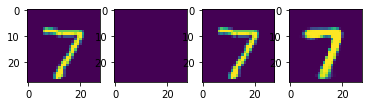

L2_distance: 31.374652862548828  Model_fooled : False  d<=theta True


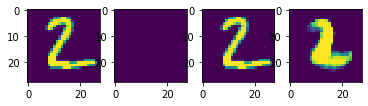

L2_distance: 72.64511108398438  Model_fooled : False  d<=theta True


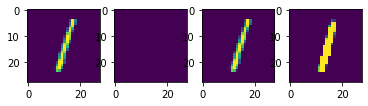

L2_distance: 11.191723823547363  Model_fooled : False  d<=theta True


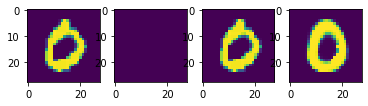

L2_distance: 36.83690643310547  Model_fooled : False  d<=theta True


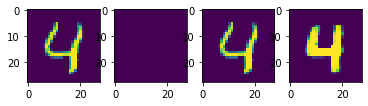

L2_distance: 38.711204528808594  Model_fooled : False  d<=theta True


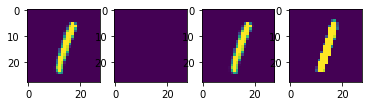

L2_distance: 6.663216590881348  Model_fooled : False  d<=theta True


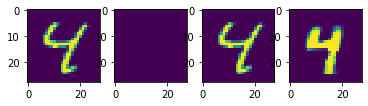

L2_distance: 43.29717254638672  Model_fooled : False  d<=theta True


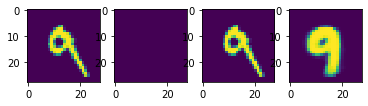

L2_distance: 66.25098419189453  Model_fooled : False  d<=theta True


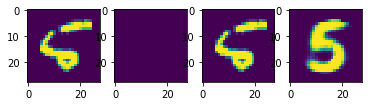

L2_distance: 132.1266632080078  Model_fooled : False  d<=theta False


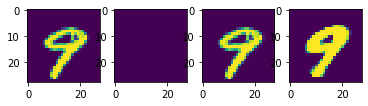

L2_distance: 31.710161209106445  Model_fooled : False  d<=theta True


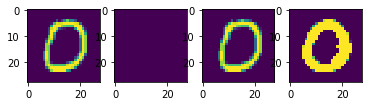

L2_distance: 66.36592102050781  Model_fooled : False  d<=theta True


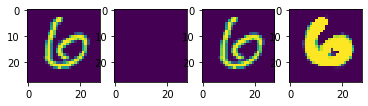

L2_distance: 98.18928527832031  Model_fooled : False  d<=theta False


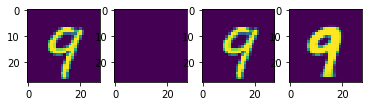

L2_distance: 27.530460357666016  Model_fooled : False  d<=theta True


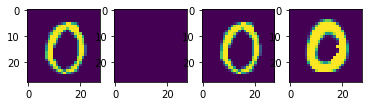

L2_distance: 46.67816925048828  Model_fooled : False  d<=theta True


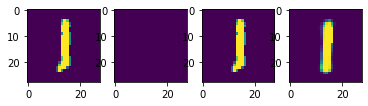

L2_distance: 9.048166275024414  Model_fooled : False  d<=theta True


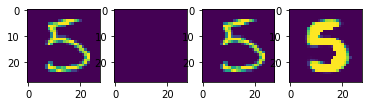

L2_distance: 78.06867980957031  Model_fooled : False  d<=theta True


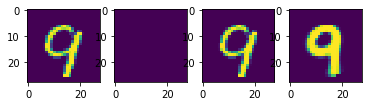

L2_distance: 42.56986999511719  Model_fooled : False  d<=theta True


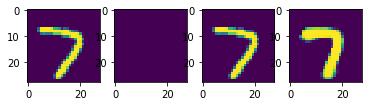

L2_distance: 46.95879364013672  Model_fooled : False  d<=theta True


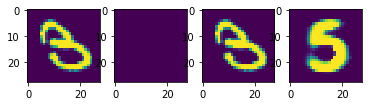

L2_distance: 114.22555541992188  Model_fooled : True  d<=theta False


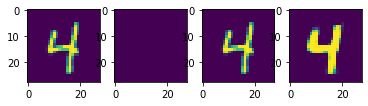

L2_distance: 24.990808486938477  Model_fooled : False  d<=theta True


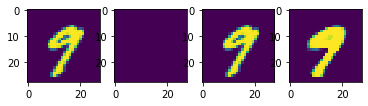

L2_distance: 15.890823364257812  Model_fooled : False  d<=theta True


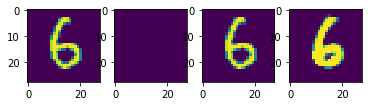

L2_distance: 46.71038055419922  Model_fooled : False  d<=theta True


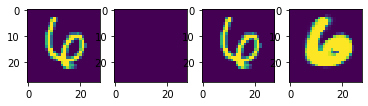

L2_distance: 105.92560577392578  Model_fooled : False  d<=theta False


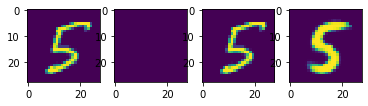

L2_distance: 40.50899124145508  Model_fooled : False  d<=theta True


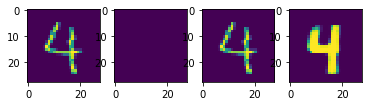

L2_distance: 48.758262634277344  Model_fooled : False  d<=theta True


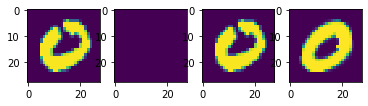

L2_distance: 41.99444580078125  Model_fooled : False  d<=theta True


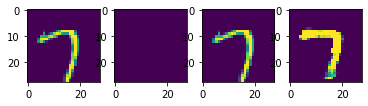

L2_distance: 28.93534278869629  Model_fooled : False  d<=theta True


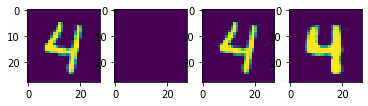

L2_distance: 48.438758850097656  Model_fooled : False  d<=theta True


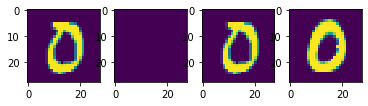

L2_distance: 28.308284759521484  Model_fooled : False  d<=theta True


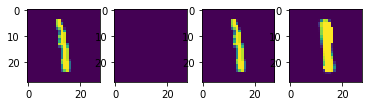

L2_distance: 28.07420539855957  Model_fooled : False  d<=theta True


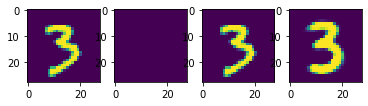

L2_distance: 45.40470504760742  Model_fooled : False  d<=theta True


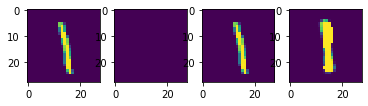










  0%|          | 0/313 [00:00<?, ?it/s]

L2_distance: 23.551952362060547  Model_fooled : False  d<=theta True
THE ADVERSARY IS : PGD


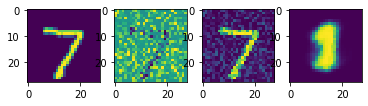

L2_distance: 83.97798156738281  Model_fooled : True  d<=theta True


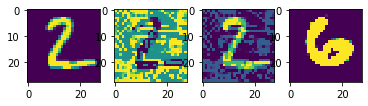

L2_distance: 155.7598876953125  Model_fooled : True  d<=theta False


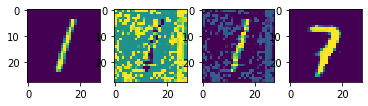

L2_distance: 61.96083450317383  Model_fooled : True  d<=theta True


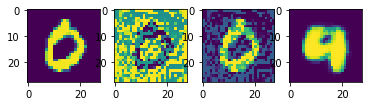

L2_distance: 106.7225112915039  Model_fooled : True  d<=theta False


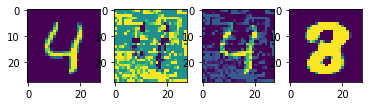

L2_distance: 134.4058837890625  Model_fooled : True  d<=theta False


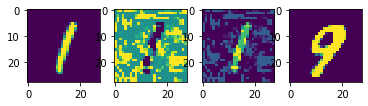

L2_distance: 90.21561431884766  Model_fooled : True  d<=theta True


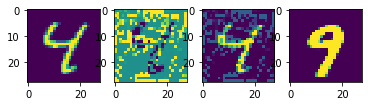

L2_distance: 81.09213256835938  Model_fooled : True  d<=theta True


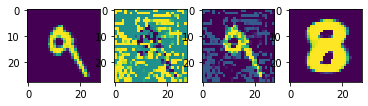

L2_distance: 160.28587341308594  Model_fooled : True  d<=theta False


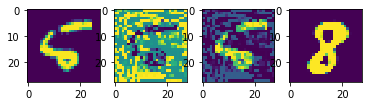

L2_distance: 137.41575622558594  Model_fooled : True  d<=theta False


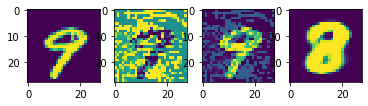

L2_distance: 112.51038360595703  Model_fooled : True  d<=theta False


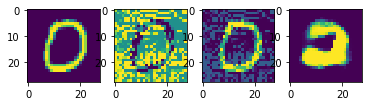

L2_distance: 116.21678161621094  Model_fooled : True  d<=theta False


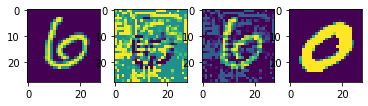

L2_distance: 156.4608154296875  Model_fooled : True  d<=theta False


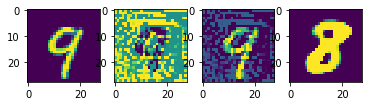

L2_distance: 144.45681762695312  Model_fooled : True  d<=theta False


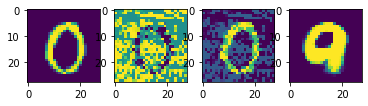

L2_distance: 102.50740051269531  Model_fooled : True  d<=theta False


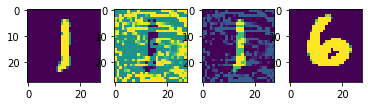

L2_distance: 151.06448364257812  Model_fooled : True  d<=theta False


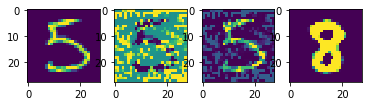

L2_distance: 143.85513305664062  Model_fooled : True  d<=theta False


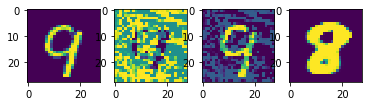

L2_distance: 129.59478759765625  Model_fooled : True  d<=theta False


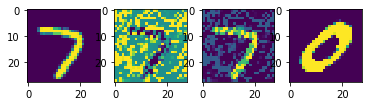

L2_distance: 139.67727661132812  Model_fooled : True  d<=theta False


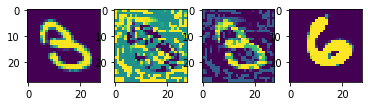

L2_distance: 148.2923126220703  Model_fooled : True  d<=theta False


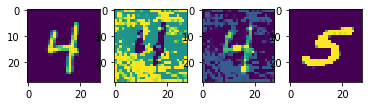

L2_distance: 104.54535675048828  Model_fooled : True  d<=theta False


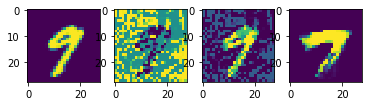

L2_distance: 73.2203140258789  Model_fooled : True  d<=theta True


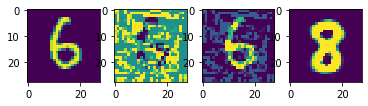

L2_distance: 107.21310424804688  Model_fooled : True  d<=theta False


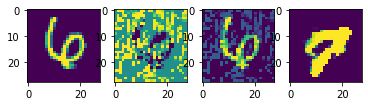

L2_distance: 128.42652893066406  Model_fooled : True  d<=theta False


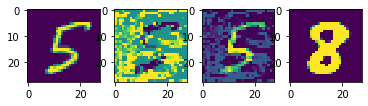

L2_distance: 136.84815979003906  Model_fooled : True  d<=theta False


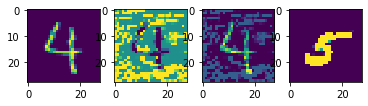

L2_distance: 114.31900787353516  Model_fooled : True  d<=theta False


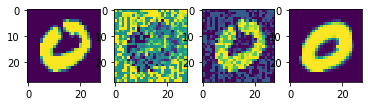

L2_distance: 58.576332092285156  Model_fooled : False  d<=theta True


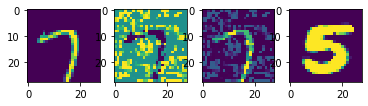

L2_distance: 155.37652587890625  Model_fooled : True  d<=theta False


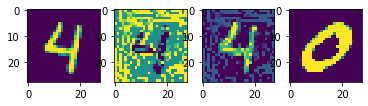

L2_distance: 158.43096923828125  Model_fooled : True  d<=theta False


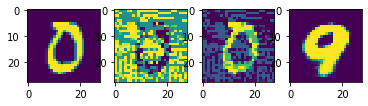

L2_distance: 114.62947082519531  Model_fooled : True  d<=theta False


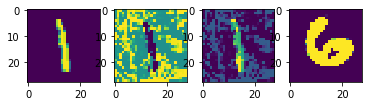

L2_distance: 157.94674682617188  Model_fooled : True  d<=theta False


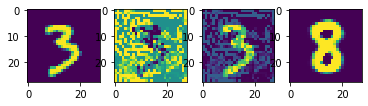

L2_distance: 103.92445373535156  Model_fooled : True  d<=theta False


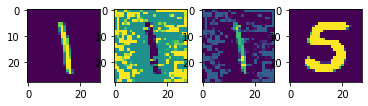











  0%|          | 0/313 [00:00<?, ?it/s]

L2_distance: 150.4168701171875  Model_fooled : True  d<=theta False
THE ADVERSARY IS : FGSM


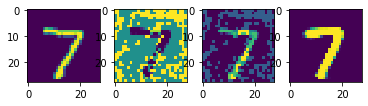

L2_distance: 56.25390625  Model_fooled : False  d<=theta True


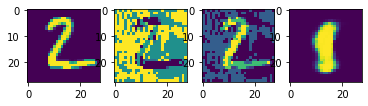

L2_distance: 102.73970031738281  Model_fooled : True  d<=theta False


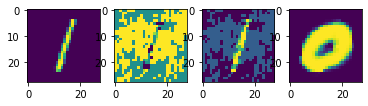

L2_distance: 160.16458129882812  Model_fooled : True  d<=theta False


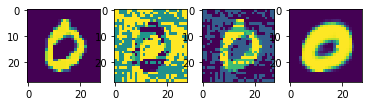

L2_distance: 84.35934448242188  Model_fooled : False  d<=theta True


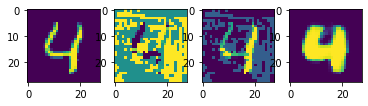

L2_distance: 94.20716857910156  Model_fooled : False  d<=theta True


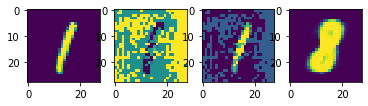

L2_distance: 116.74444580078125  Model_fooled : True  d<=theta False


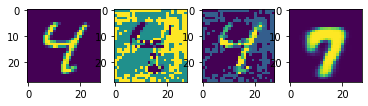

L2_distance: 87.71643829345703  Model_fooled : True  d<=theta True


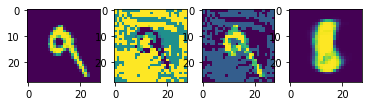

L2_distance: 89.98008728027344  Model_fooled : True  d<=theta True


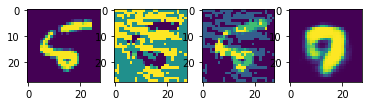

L2_distance: 88.28970336914062  Model_fooled : True  d<=theta True


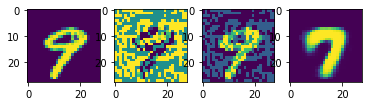

L2_distance: 89.25861358642578  Model_fooled : True  d<=theta True


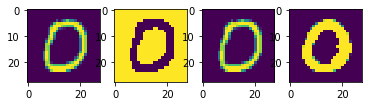

L2_distance: 66.36436462402344  Model_fooled : False  d<=theta True


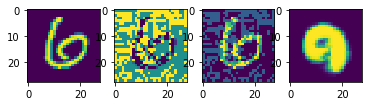

L2_distance: 131.1796875  Model_fooled : True  d<=theta False


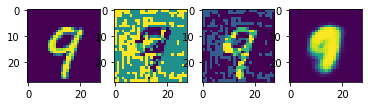

L2_distance: 70.13169860839844  Model_fooled : False  d<=theta True


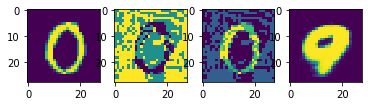

L2_distance: 142.21685791015625  Model_fooled : True  d<=theta False


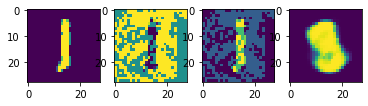

L2_distance: 100.74549102783203  Model_fooled : True  d<=theta False


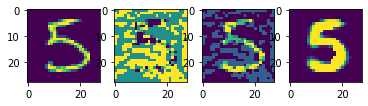

L2_distance: 83.09651184082031  Model_fooled : False  d<=theta True


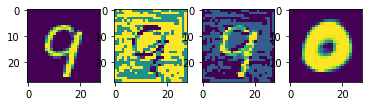

L2_distance: 136.71310424804688  Model_fooled : True  d<=theta False


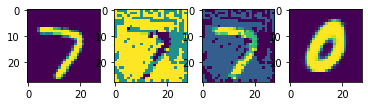

L2_distance: 112.61550903320312  Model_fooled : True  d<=theta False


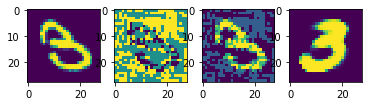

L2_distance: 139.90060424804688  Model_fooled : False  d<=theta False


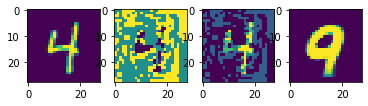

L2_distance: 86.61164855957031  Model_fooled : True  d<=theta True


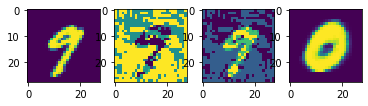

L2_distance: 101.72418212890625  Model_fooled : True  d<=theta False


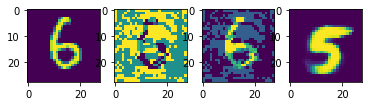

L2_distance: 83.94015502929688  Model_fooled : True  d<=theta True


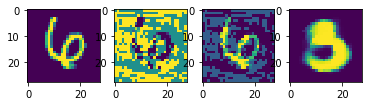

L2_distance: 135.7672119140625  Model_fooled : True  d<=theta False


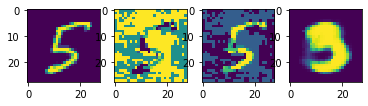

L2_distance: 107.9609146118164  Model_fooled : True  d<=theta False


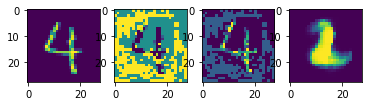

L2_distance: 108.83358764648438  Model_fooled : True  d<=theta False


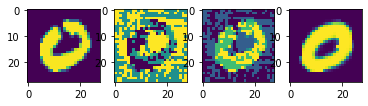

L2_distance: 60.30923843383789  Model_fooled : False  d<=theta True


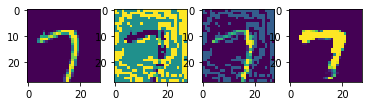

L2_distance: 74.59930419921875  Model_fooled : False  d<=theta True


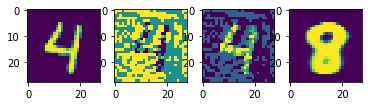

L2_distance: 112.90476989746094  Model_fooled : True  d<=theta False


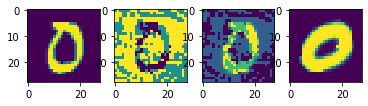

L2_distance: 101.02500915527344  Model_fooled : False  d<=theta False


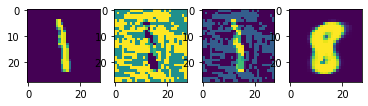

L2_distance: 121.3179702758789  Model_fooled : True  d<=theta False


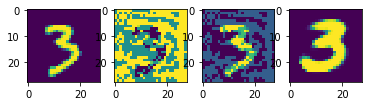

L2_distance: 96.44290161132812  Model_fooled : False  d<=theta False


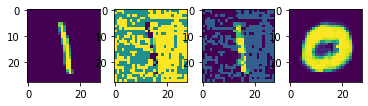












  0%|          | 0/313 [00:00<?, ?it/s]

L2_distance: 152.69439697265625  Model_fooled : True  d<=theta False
THE ADVERSARY IS : BIM


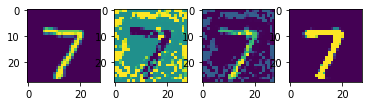

L2_distance: 42.851539611816406  Model_fooled : False  d<=theta True


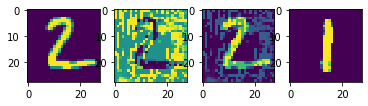

L2_distance: 105.36982727050781  Model_fooled : True  d<=theta False


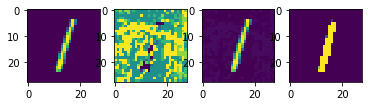

L2_distance: 12.587200164794922  Model_fooled : False  d<=theta True


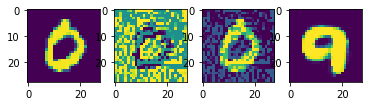

L2_distance: 115.89114379882812  Model_fooled : True  d<=theta False


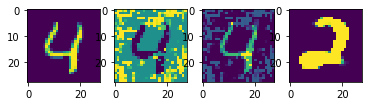

L2_distance: 133.48736572265625  Model_fooled : True  d<=theta False


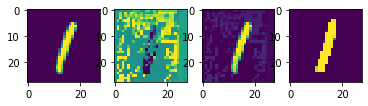

L2_distance: 18.58619499206543  Model_fooled : False  d<=theta True


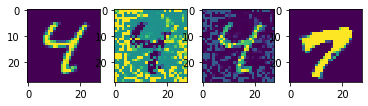

L2_distance: 117.89910125732422  Model_fooled : True  d<=theta False


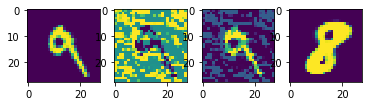

L2_distance: 162.85601806640625  Model_fooled : True  d<=theta False


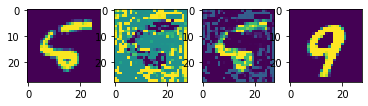

L2_distance: 104.73805236816406  Model_fooled : True  d<=theta False


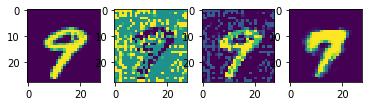

L2_distance: 52.916099548339844  Model_fooled : True  d<=theta True


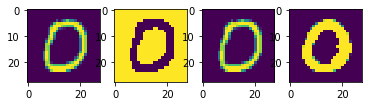

L2_distance: 66.36436462402344  Model_fooled : False  d<=theta True


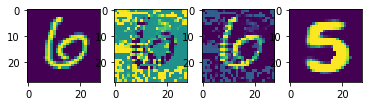

L2_distance: 139.3038330078125  Model_fooled : True  d<=theta False


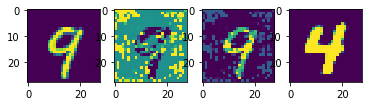

L2_distance: 78.69190979003906  Model_fooled : True  d<=theta True


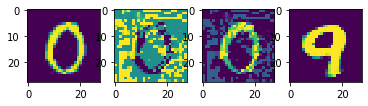

L2_distance: 109.0758056640625  Model_fooled : True  d<=theta False


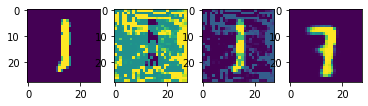

L2_distance: 55.15410614013672  Model_fooled : True  d<=theta True


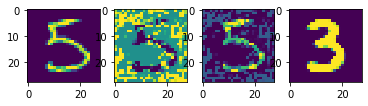

L2_distance: 105.0195083618164  Model_fooled : True  d<=theta False


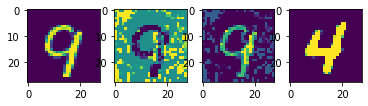

L2_distance: 75.99783325195312  Model_fooled : True  d<=theta True


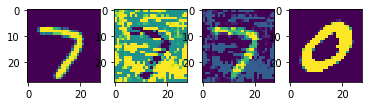

L2_distance: 145.87843322753906  Model_fooled : True  d<=theta False


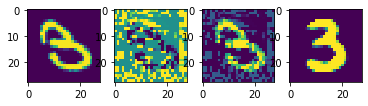

L2_distance: 109.50749206542969  Model_fooled : False  d<=theta False


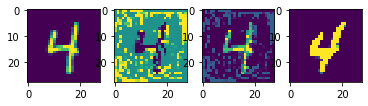

L2_distance: 75.00982666015625  Model_fooled : False  d<=theta True


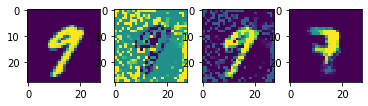

L2_distance: 68.16801452636719  Model_fooled : True  d<=theta True


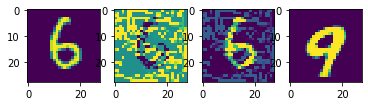

L2_distance: 118.54972839355469  Model_fooled : True  d<=theta False


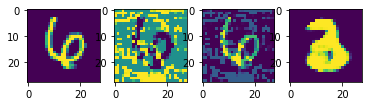

L2_distance: 149.08859252929688  Model_fooled : True  d<=theta False


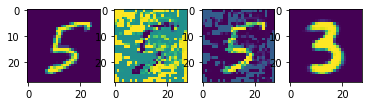

L2_distance: 88.60124206542969  Model_fooled : True  d<=theta True


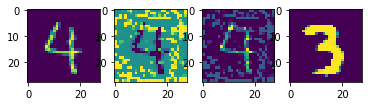

L2_distance: 107.63075256347656  Model_fooled : True  d<=theta False


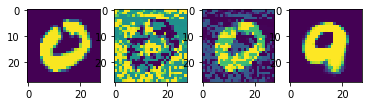

L2_distance: 91.07548522949219  Model_fooled : True  d<=theta True


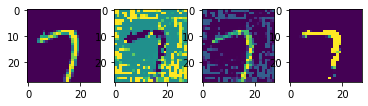

L2_distance: 45.53399658203125  Model_fooled : False  d<=theta True


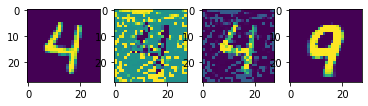

L2_distance: 68.03753662109375  Model_fooled : True  d<=theta True


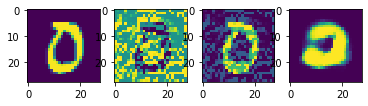

L2_distance: 89.83411407470703  Model_fooled : True  d<=theta True


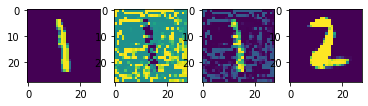

L2_distance: 97.09046936035156  Model_fooled : True  d<=theta False


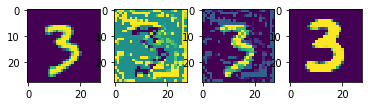

L2_distance: 78.06640625  Model_fooled : False  d<=theta True


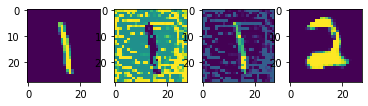

L2_distance: 119.06964111328125  Model_fooled : True  d<=theta False


In [13]:
from advertorch.attacks.base import Attack, LabelMixin
from advertorch.utils import clamp

class CleanAttack(Attack, LabelMixin):
    def __init__(self, clip_min=0., clip_max=1.):
        super(CleanAttack, self).__init__(None,None,clip_min, clip_max)

    def perturb(self, x, y=None):
#         xadv = x.requires_grad_()
#         xadv = clamp(xadv, self.clip_min, self.clip_max)
#         return xadv.detach()
        return x
    
model_for_adversary = Model_for_Adversary(net)
    
linf_eps = 0.3
fgsm_step = 0.05
bim_pgd_step = 0.01

adversary_dict = {}
adversary_dict['Clean'] = CleanAttack(clip_min=-0.4242, clip_max=2.8215)
adversary_dict['PGD'] = LinfPGDAttack(
    model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(linf_eps/0.3081),
    nb_iter=1000, eps_iter=(bim_pgd_step/0.3081), rand_init=True, clip_min=-0.4242, clip_max=2.8215,
    targeted=False)

adversary_dict['FGSM'] = GradientSignAttack(model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(linf_eps/0.3081), clip_min=-0.4242, clip_max=2.8215, targeted=False)
adversary_dict['BIM'] = LinfBasicIterativeAttack(model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(linf_eps/0.3081), nb_iter=1000, eps_iter=(bim_pgd_step/0.3081), clip_min=-0.4242, clip_max=2.8215, targeted=False)
# adversary_dict['CW'] = CarliniWagnerL2Attack(model_for_adversary, num_classes=args['num_classes'], confidence=0, targeted=False, learning_rate=0.01, binary_search_steps=9, max_iterations=1000, abort_early=True, initial_const=0.001, clip_min=-0.4242, clip_max=2.8215, loss_fn=None)

WhiteBox_Attacks_Untargeted(net, testloader, adversary_dict, args, 96)













  0%|          | 0/313 [00:00<?, ?it/s]

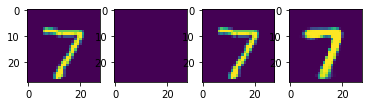

L2_distance: 31.374652862548828 Target:  9 Model_fooled : False : d <= theta True


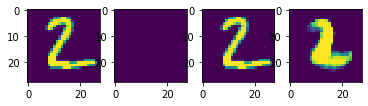

L2_distance: 72.64511108398438 Target:  7 Model_fooled : False : d <= theta True


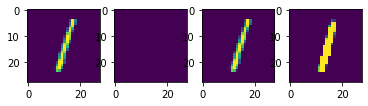

L2_distance: 11.191723823547363 Target:  7 Model_fooled : False : d <= theta True


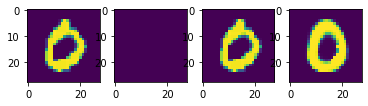

L2_distance: 36.83690643310547 Target:  2 Model_fooled : False : d <= theta True


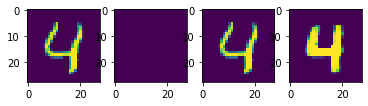

L2_distance: 38.711204528808594 Target:  2 Model_fooled : False : d <= theta True


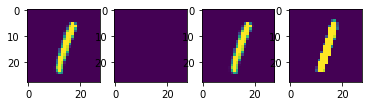

L2_distance: 6.663216590881348 Target:  4 Model_fooled : False : d <= theta True


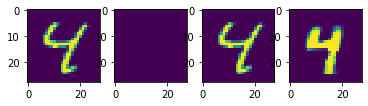

L2_distance: 43.29717254638672 Target:  5 Model_fooled : False : d <= theta True


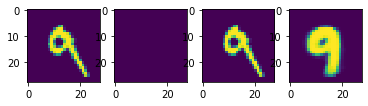

L2_distance: 66.25098419189453 Target:  1 Model_fooled : False : d <= theta True


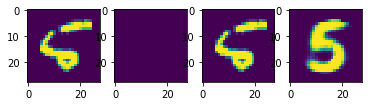

L2_distance: 132.1266632080078 Target:  2 Model_fooled : False : d <= theta False


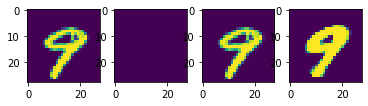

L2_distance: 31.710161209106445 Target:  6 Model_fooled : False : d <= theta True


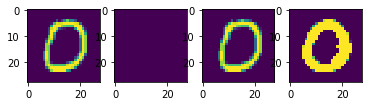

L2_distance: 66.36592102050781 Target:  9 Model_fooled : False : d <= theta True


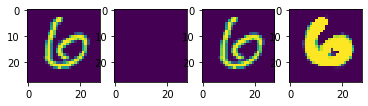

L2_distance: 98.18928527832031 Target:  8 Model_fooled : False : d <= theta False


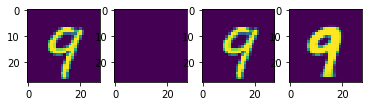

L2_distance: 27.530460357666016 Target:  9 Model_fooled : True : d <= theta True


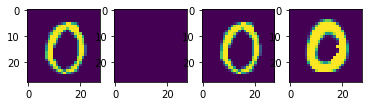

L2_distance: 46.67816925048828 Target:  5 Model_fooled : False : d <= theta True


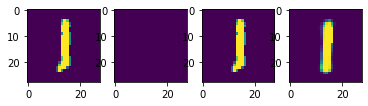

L2_distance: 9.048166275024414 Target:  9 Model_fooled : False : d <= theta True


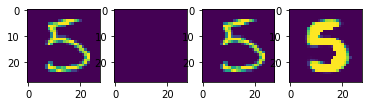

L2_distance: 78.06867980957031 Target:  5 Model_fooled : True : d <= theta True


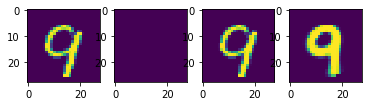

L2_distance: 42.56986999511719 Target:  5 Model_fooled : False : d <= theta True


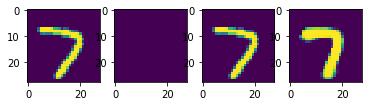

L2_distance: 46.95879364013672 Target:  0 Model_fooled : False : d <= theta True


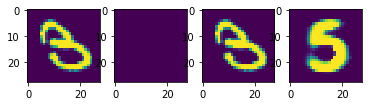

L2_distance: 114.22555541992188 Target:  4 Model_fooled : False : d <= theta False


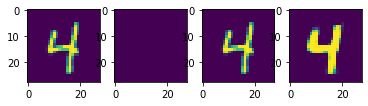

L2_distance: 24.990808486938477 Target:  8 Model_fooled : False : d <= theta True


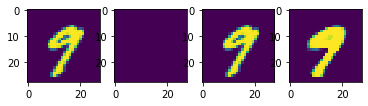

L2_distance: 15.890823364257812 Target:  7 Model_fooled : False : d <= theta True


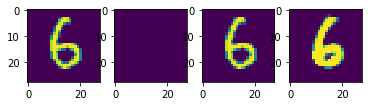

L2_distance: 46.71038055419922 Target:  2 Model_fooled : False : d <= theta True


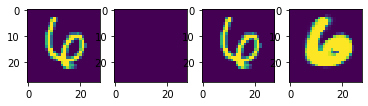

L2_distance: 105.92560577392578 Target:  2 Model_fooled : False : d <= theta False


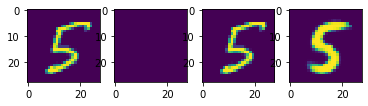

L2_distance: 40.50899124145508 Target:  4 Model_fooled : False : d <= theta True


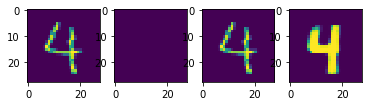

L2_distance: 48.758262634277344 Target:  0 Model_fooled : False : d <= theta True


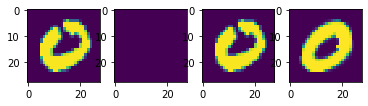

L2_distance: 41.99444580078125 Target:  0 Model_fooled : True : d <= theta True


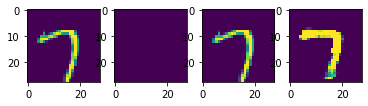

L2_distance: 28.93534278869629 Target:  8 Model_fooled : False : d <= theta True


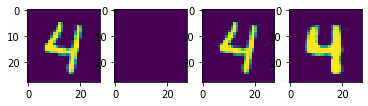

L2_distance: 48.438758850097656 Target:  0 Model_fooled : False : d <= theta True


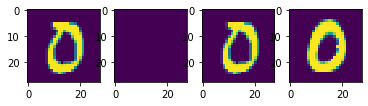

L2_distance: 28.308284759521484 Target:  7 Model_fooled : False : d <= theta True


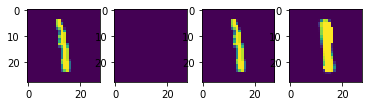

L2_distance: 28.07420539855957 Target:  6 Model_fooled : False : d <= theta True


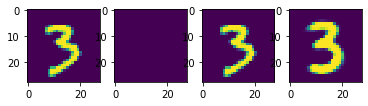

L2_distance: 45.40470504760742 Target:  0 Model_fooled : False : d <= theta True


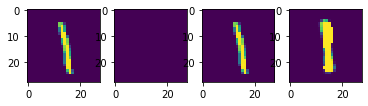














  0%|          | 0/313 [00:00<?, ?it/s]

L2_distance: 23.551952362060547 Target:  3 Model_fooled : False : d <= theta True


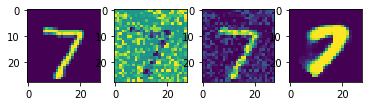

L2_distance: 84.71661376953125 Target:  4 Model_fooled : False : d <= theta True


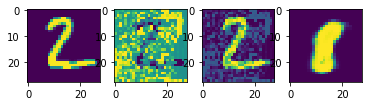

L2_distance: 104.81166076660156 Target:  8 Model_fooled : True : d <= theta False


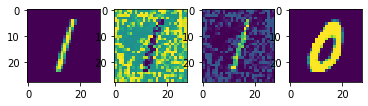

L2_distance: 120.59390258789062 Target:  0 Model_fooled : True : d <= theta False


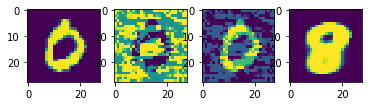

L2_distance: 97.63252258300781 Target:  8 Model_fooled : True : d <= theta False


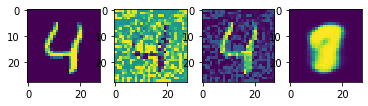

L2_distance: 102.35600280761719 Target:  5 Model_fooled : False : d <= theta False


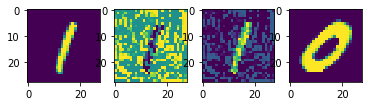

L2_distance: 145.56719970703125 Target:  0 Model_fooled : True : d <= theta False


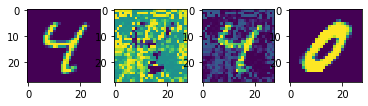

L2_distance: 130.41416931152344 Target:  0 Model_fooled : True : d <= theta False


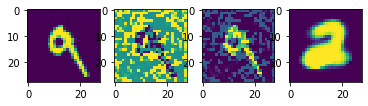

L2_distance: 137.80931091308594 Target:  2 Model_fooled : True : d <= theta False


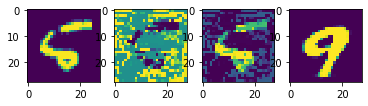

L2_distance: 117.52854919433594 Target:  9 Model_fooled : True : d <= theta False


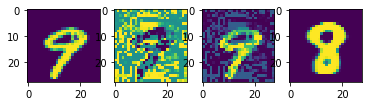

L2_distance: 92.4112548828125 Target:  8 Model_fooled : True : d <= theta True


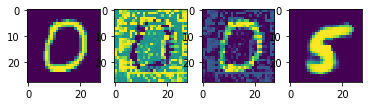

L2_distance: 139.58006286621094 Target:  5 Model_fooled : True : d <= theta False


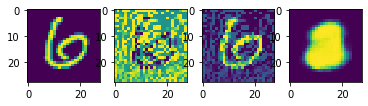

L2_distance: 117.9122314453125 Target:  3 Model_fooled : False : d <= theta False


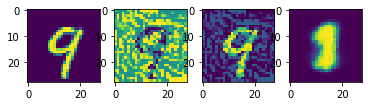

L2_distance: 72.86333465576172 Target:  1 Model_fooled : True : d <= theta True


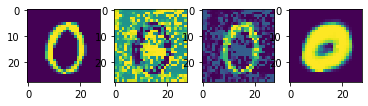

L2_distance: 115.46987915039062 Target:  1 Model_fooled : False : d <= theta False


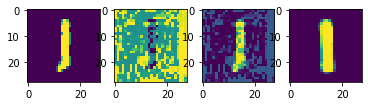

L2_distance: 43.09282302856445 Target:  1 Model_fooled : True : d <= theta True


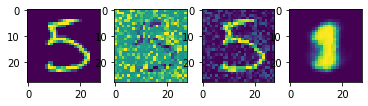

L2_distance: 110.17813110351562 Target:  6 Model_fooled : False : d <= theta False


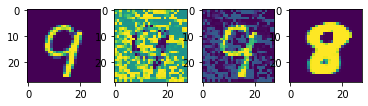

L2_distance: 116.03524780273438 Target:  8 Model_fooled : True : d <= theta False


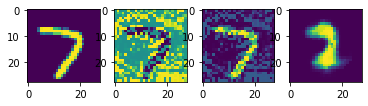

L2_distance: 79.38426971435547 Target:  3 Model_fooled : False : d <= theta True


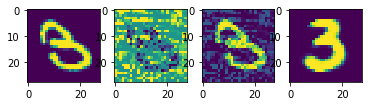

L2_distance: 121.63387298583984 Target:  3 Model_fooled : True : d <= theta False


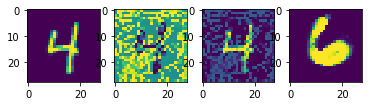

L2_distance: 106.35853576660156 Target:  6 Model_fooled : True : d <= theta False


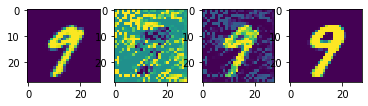

L2_distance: 39.072654724121094 Target:  9 Model_fooled : True : d <= theta True


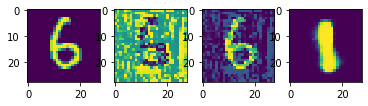

L2_distance: 88.93856811523438 Target:  1 Model_fooled : True : d <= theta True


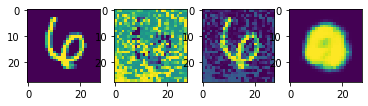

L2_distance: 113.38972473144531 Target:  7 Model_fooled : False : d <= theta False


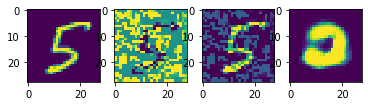

L2_distance: 134.3213348388672 Target:  2 Model_fooled : True : d <= theta False


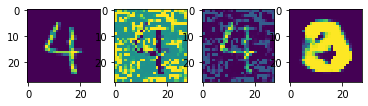

L2_distance: 193.32167053222656 Target:  3 Model_fooled : True : d <= theta False


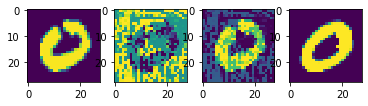

L2_distance: 79.74800109863281 Target:  0 Model_fooled : True : d <= theta True


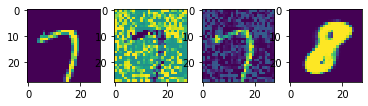

L2_distance: 158.4564971923828 Target:  8 Model_fooled : True : d <= theta False


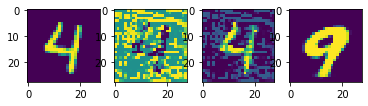

L2_distance: 95.78529357910156 Target:  9 Model_fooled : True : d <= theta True


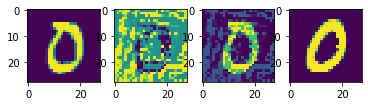

L2_distance: 67.24287414550781 Target:  0 Model_fooled : True : d <= theta True


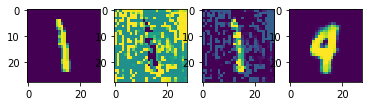

L2_distance: 84.16477966308594 Target:  4 Model_fooled : True : d <= theta True


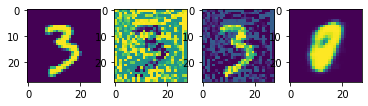

L2_distance: 104.36222076416016 Target:  4 Model_fooled : False : d <= theta False


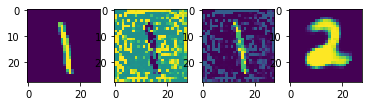















  0%|          | 0/313 [00:00<?, ?it/s]

L2_distance: 126.89169311523438 Target:  2 Model_fooled : True : d <= theta False


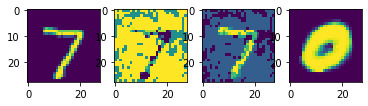

L2_distance: 135.36090087890625 Target:  0 Model_fooled : True : d <= theta False


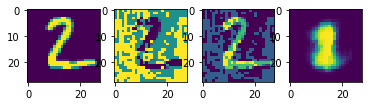

L2_distance: 99.84917449951172 Target:  4 Model_fooled : False : d <= theta False


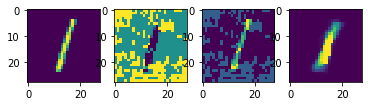

L2_distance: 42.236270904541016 Target:  3 Model_fooled : False : d <= theta True


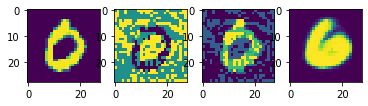

L2_distance: 74.72870635986328 Target:  3 Model_fooled : False : d <= theta True


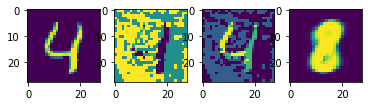

L2_distance: 131.1289825439453 Target:  3 Model_fooled : False : d <= theta False


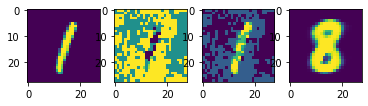

L2_distance: 95.18827819824219 Target:  8 Model_fooled : True : d <= theta True


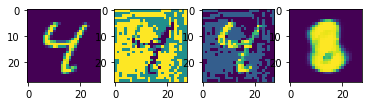

L2_distance: 118.26783752441406 Target:  0 Model_fooled : False : d <= theta False


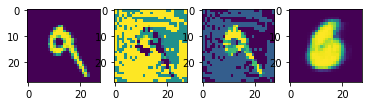

L2_distance: 95.45561218261719 Target:  2 Model_fooled : False : d <= theta True


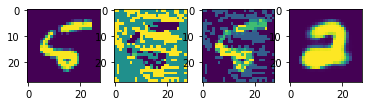

L2_distance: 113.70501708984375 Target:  3 Model_fooled : False : d <= theta False


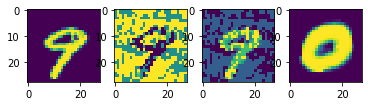

L2_distance: 134.882080078125 Target:  2 Model_fooled : False : d <= theta False


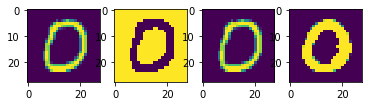

L2_distance: 66.36436462402344 Target:  0 Model_fooled : True : d <= theta True


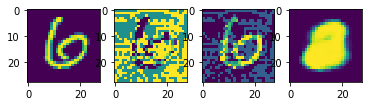

L2_distance: 133.03945922851562 Target:  3 Model_fooled : False : d <= theta False


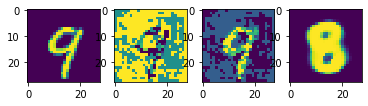

L2_distance: 118.13127136230469 Target:  2 Model_fooled : False : d <= theta False


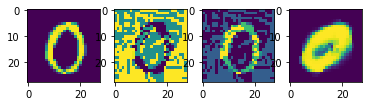

L2_distance: 144.87127685546875 Target:  6 Model_fooled : False : d <= theta False


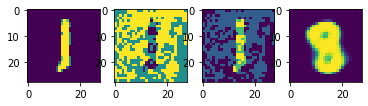

L2_distance: 117.55906677246094 Target:  9 Model_fooled : False : d <= theta False


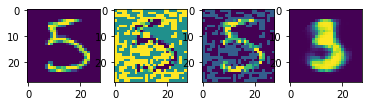

L2_distance: 98.03050994873047 Target:  3 Model_fooled : True : d <= theta False


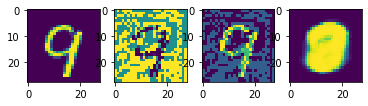

L2_distance: 140.7646942138672 Target:  8 Model_fooled : True : d <= theta False


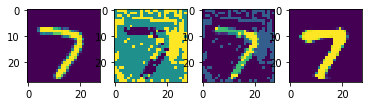

L2_distance: 69.53460693359375 Target:  7 Model_fooled : True : d <= theta True


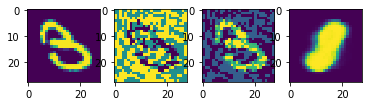

L2_distance: 137.9705810546875 Target:  2 Model_fooled : False : d <= theta False


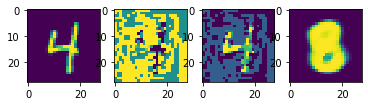

L2_distance: 115.67593383789062 Target:  4 Model_fooled : False : d <= theta False


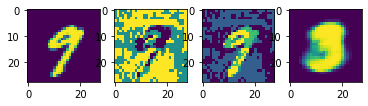

L2_distance: 89.53567504882812 Target:  5 Model_fooled : False : d <= theta True


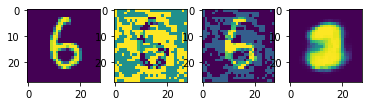

L2_distance: 98.80306243896484 Target:  7 Model_fooled : False : d <= theta False


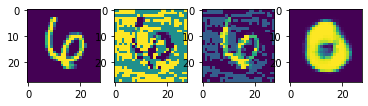

L2_distance: 127.86835479736328 Target:  5 Model_fooled : False : d <= theta False


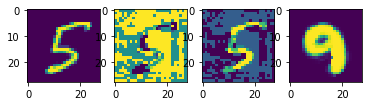

L2_distance: 118.94086456298828 Target:  9 Model_fooled : True : d <= theta False


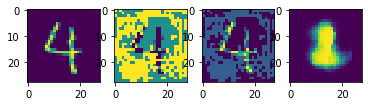

L2_distance: 104.16842651367188 Target:  0 Model_fooled : False : d <= theta False


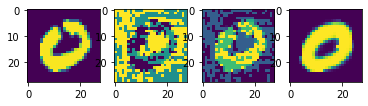

L2_distance: 62.10100173950195 Target:  9 Model_fooled : False : d <= theta True


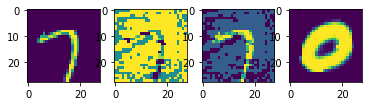

L2_distance: 142.0010986328125 Target:  2 Model_fooled : False : d <= theta False


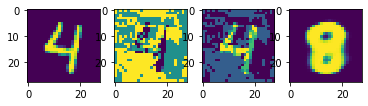

L2_distance: 117.25894927978516 Target:  2 Model_fooled : False : d <= theta False


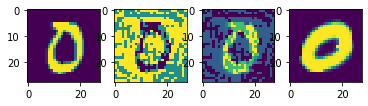

L2_distance: 102.74030303955078 Target:  3 Model_fooled : False : d <= theta False


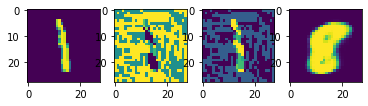

L2_distance: 141.6349334716797 Target:  9 Model_fooled : False : d <= theta False


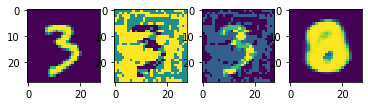

L2_distance: 126.44190979003906 Target:  0 Model_fooled : False : d <= theta False


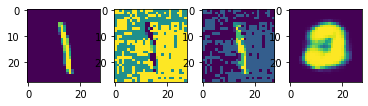
















  0%|          | 0/313 [00:00<?, ?it/s]

L2_distance: 136.55503845214844 Target:  6 Model_fooled : False : d <= theta False


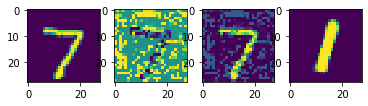

L2_distance: 101.41319274902344 Target:  1 Model_fooled : True : d <= theta False


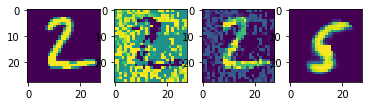

L2_distance: 103.51947021484375 Target:  5 Model_fooled : True : d <= theta False


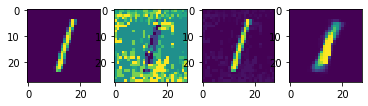

L2_distance: 15.214193344116211 Target:  5 Model_fooled : False : d <= theta True


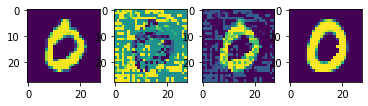

L2_distance: 57.611778259277344 Target:  0 Model_fooled : True : d <= theta True


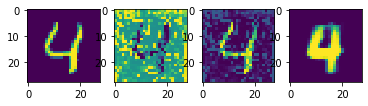

L2_distance: 74.8250732421875 Target:  4 Model_fooled : True : d <= theta True


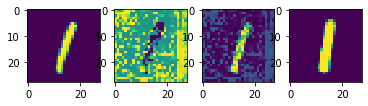

L2_distance: 40.776939392089844 Target:  1 Model_fooled : True : d <= theta True


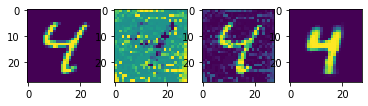

L2_distance: 50.080810546875 Target:  4 Model_fooled : True : d <= theta True


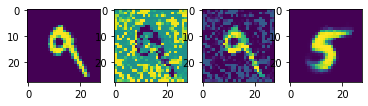

L2_distance: 78.20288848876953 Target:  5 Model_fooled : True : d <= theta True


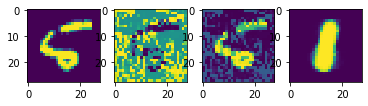

L2_distance: 105.7211685180664 Target:  1 Model_fooled : True : d <= theta False


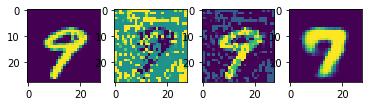

L2_distance: 89.56412506103516 Target:  7 Model_fooled : True : d <= theta True


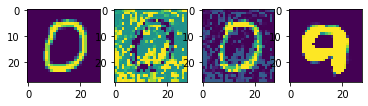

L2_distance: 149.65052795410156 Target:  9 Model_fooled : True : d <= theta False


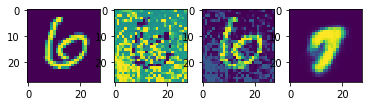

L2_distance: 104.76203155517578 Target:  7 Model_fooled : True : d <= theta False


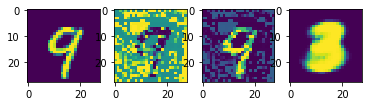

L2_distance: 129.06573486328125 Target:  3 Model_fooled : True : d <= theta False


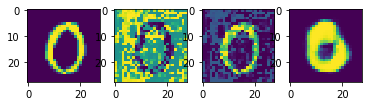

L2_distance: 97.87245178222656 Target:  4 Model_fooled : False : d <= theta False


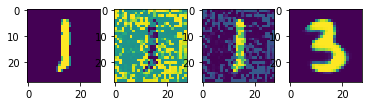

L2_distance: 91.97674560546875 Target:  3 Model_fooled : True : d <= theta True


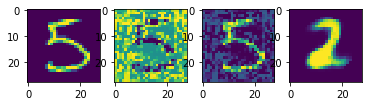

L2_distance: 119.33250427246094 Target:  2 Model_fooled : True : d <= theta False


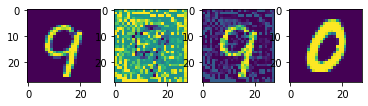

L2_distance: 122.77672576904297 Target:  0 Model_fooled : True : d <= theta False


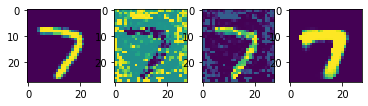

L2_distance: 90.94574737548828 Target:  7 Model_fooled : True : d <= theta True


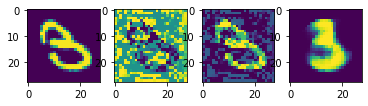

L2_distance: 90.2358169555664 Target:  7 Model_fooled : False : d <= theta True


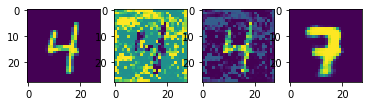

L2_distance: 88.20186614990234 Target:  7 Model_fooled : True : d <= theta True


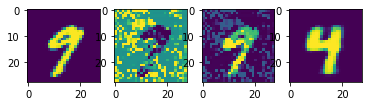

L2_distance: 67.42376708984375 Target:  4 Model_fooled : True : d <= theta True


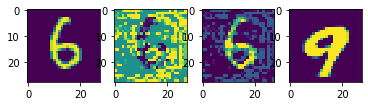

L2_distance: 127.80908966064453 Target:  9 Model_fooled : True : d <= theta False


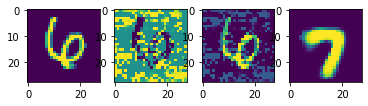

L2_distance: 109.44023132324219 Target:  7 Model_fooled : True : d <= theta False


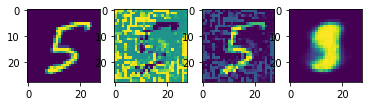

L2_distance: 86.38251495361328 Target:  7 Model_fooled : False : d <= theta True


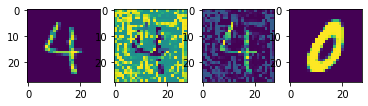

L2_distance: 139.9999237060547 Target:  0 Model_fooled : True : d <= theta False


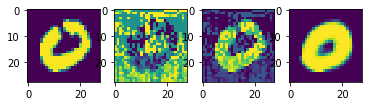

L2_distance: 58.84556579589844 Target:  7 Model_fooled : False : d <= theta True


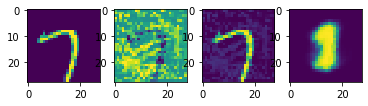

L2_distance: 88.51963806152344 Target:  6 Model_fooled : False : d <= theta True


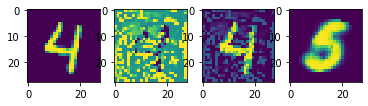

L2_distance: 115.48055267333984 Target:  5 Model_fooled : True : d <= theta False


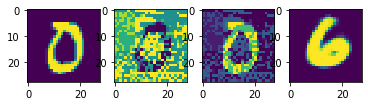

L2_distance: 110.35914611816406 Target:  6 Model_fooled : True : d <= theta False


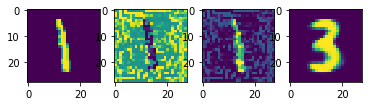

L2_distance: 91.70533752441406 Target:  3 Model_fooled : True : d <= theta True


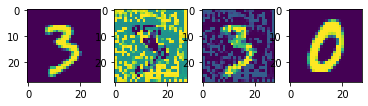

L2_distance: 105.76155090332031 Target:  0 Model_fooled : True : d <= theta False


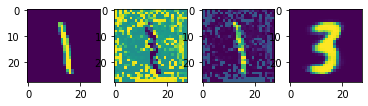

L2_distance: 87.1585922241211 Target:  3 Model_fooled : True : d <= theta True


In [14]:
model_for_adversary = Model_for_Adversary(net)
    
linf_eps = 0.3
fgsm_step = 0.05
bim_pgd_step = 0.01

adversary_dict = {}
adversary_dict['Clean'] = CleanAttack(clip_min=-0.4242, clip_max=2.8215)
adversary_dict['PGD'] = LinfPGDAttack(
    model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(linf_eps/0.3081),
    nb_iter=1000, eps_iter=(bim_pgd_step/0.3081), rand_init=True, clip_min=-0.4242, clip_max=2.8215,
    targeted=True)

adversary_dict['FGSM'] = GradientSignAttack(model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(linf_eps/0.3081), clip_min=-0.4242, clip_max=2.8215, targeted=True)
adversary_dict['BIM'] = LinfBasicIterativeAttack(model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(linf_eps/0.3081), nb_iter=1000, eps_iter=(bim_pgd_step/0.3081), clip_min=-0.4242, clip_max=2.8215, targeted=True)
# adversary_dict['CW'] = CarliniWagnerL2Attack(model_for_adversary, num_classes=args['num_classes'], confidence=0, targeted=False, learning_rate=0.01, binary_search_steps=9, max_iterations=1000, abort_early=True, initial_const=0.001, clip_min=-0.4242, clip_max=2.8215, loss_fn=None)

WhiteBox_Attacks_Targeted(net, testloader, adversary_dict, args, 96)

## Histograms for CNN+R

In [15]:
args = {
    'DATASET_NAME':'mnist',
    'num_classes':10,
    
    'USE_CUDA': True if torch.cuda.is_available() else False,
    'BATCH_SIZE': 32,
    'N_EPOCHS': 100,
    'LEARNING_RATE_1': 1e-2,
    'LEARNING_RATE_2': 1e-2,
    'WEIGHTDECAY':5e-6,
    
    #Scheduler
    'USE_SCHEDULER':True,
    'sched_milestones':[8,20,30,40,50],
    'sched_gamma':0.1,
    
    #Loss Function
    'LAMBDA_recon': 0.5,
    'LAMBDA_class': 1,
    
    #For Decoder
    'num_features':160,
    'LReLU_negative_slope':0.1,
    'input_height':28,
    'input_width':28,
    'input_channel':1,
    'type':'plusR',
    
}

In [16]:
class Config:
    def __init__(self, dataset='mnist'):
        # CONV1
        self.conv1_in = 1
        self.conv1_out = 12
        self.conv1_kernel_size = 15

        # CONV2
        self.conv2_in = 12
        self.conv2_out = 16
        self.conv2_kernel_size = 8

        # FC1
        self.fc1_in = 7 * 7 * 16
        self.fc1_out = 784
        
        # FC1
        self.fc2_in = 784
        self.fc2_out = 160

torch.manual_seed(2)
config = Config()

net = CNNnet(args, config)

# net = torch.nn.DataParallel(net)
net.load_state_dict(torch.load(os.path.join(model_path, 'CNNplusR_mnist.pth'), map_location='cpu'))
    
if args['USE_CUDA']:
    net = net.cuda()
    

In [17]:
import matplotlib.pyplot as plt
from advertorch.attacks import LinfPGDAttack, GradientSignAttack, CarliniWagnerL2Attack, LinfBasicIterativeAttack

class Model_for_Adversary(nn.Module):
    def __init__(self, net):
        super(Model_for_Adversary, self).__init__()
        self.net = net
        
    def forward(self, x):
        output, recons, masked = self.net(x)
        classes = output.sum(2)
        return classes

















  0%|          | 0/313 [00:00<?, ?it/s]

THE ADVERSARY IS : Clean


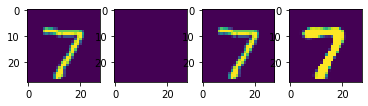

L2_distance: 30.05651092529297  Model_fooled : False  d<=theta True


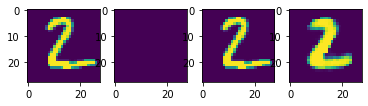

L2_distance: 42.75883865356445  Model_fooled : False  d<=theta True


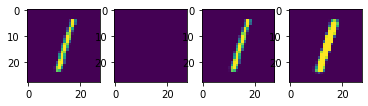

L2_distance: 12.031614303588867  Model_fooled : False  d<=theta True


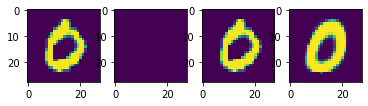

L2_distance: 35.9091796875  Model_fooled : False  d<=theta True


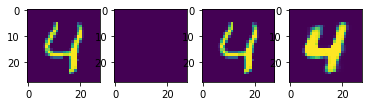

L2_distance: 48.96803283691406  Model_fooled : False  d<=theta True


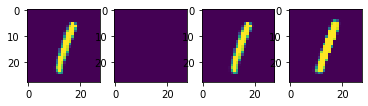

L2_distance: 5.340488433837891  Model_fooled : False  d<=theta True


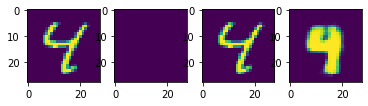

L2_distance: 76.41002655029297  Model_fooled : False  d<=theta True


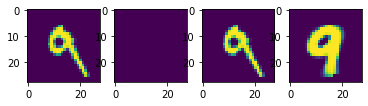

L2_distance: 83.83529663085938  Model_fooled : False  d<=theta True


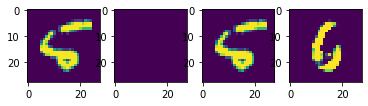

L2_distance: 91.19009399414062  Model_fooled : True  d<=theta True


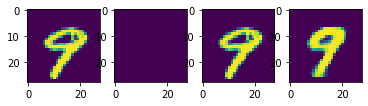

L2_distance: 23.73257064819336  Model_fooled : False  d<=theta True


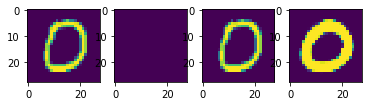

L2_distance: 72.02308654785156  Model_fooled : False  d<=theta True


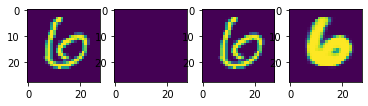

L2_distance: 84.99049377441406  Model_fooled : False  d<=theta True


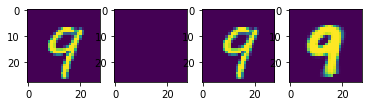

L2_distance: 45.257877349853516  Model_fooled : False  d<=theta True


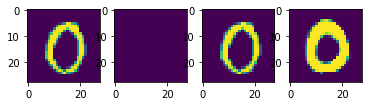

L2_distance: 57.76347351074219  Model_fooled : False  d<=theta True


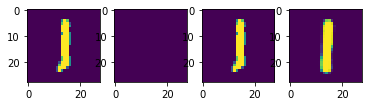

L2_distance: 10.316215515136719  Model_fooled : False  d<=theta True


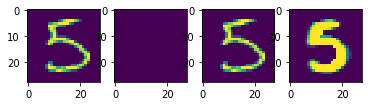

L2_distance: 74.70440673828125  Model_fooled : False  d<=theta True


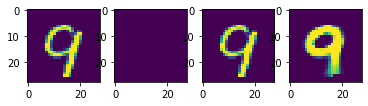

L2_distance: 41.07187271118164  Model_fooled : False  d<=theta True


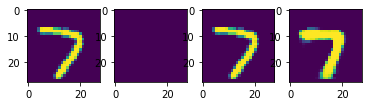

L2_distance: 48.49518966674805  Model_fooled : False  d<=theta True


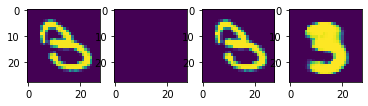

L2_distance: 119.19453430175781  Model_fooled : False  d<=theta False


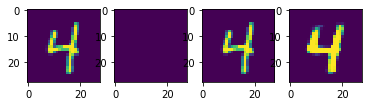

L2_distance: 28.619976043701172  Model_fooled : False  d<=theta True


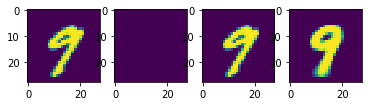

L2_distance: 28.41575813293457  Model_fooled : False  d<=theta True


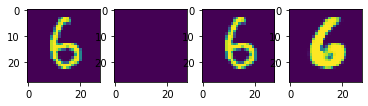

L2_distance: 64.59111022949219  Model_fooled : False  d<=theta True


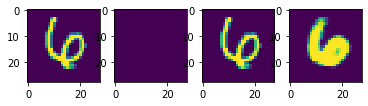

L2_distance: 76.18659973144531  Model_fooled : False  d<=theta True


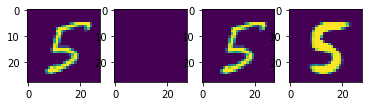

L2_distance: 54.05396270751953  Model_fooled : False  d<=theta True


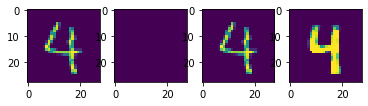

L2_distance: 40.288787841796875  Model_fooled : False  d<=theta True


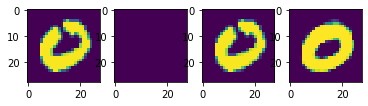

L2_distance: 48.50832748413086  Model_fooled : False  d<=theta True


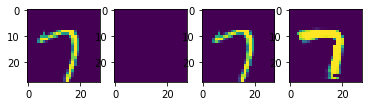

L2_distance: 39.95034408569336  Model_fooled : False  d<=theta True


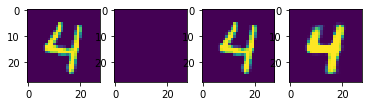

L2_distance: 28.154556274414062  Model_fooled : False  d<=theta True


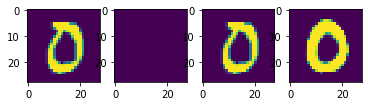

L2_distance: 41.447532653808594  Model_fooled : False  d<=theta True


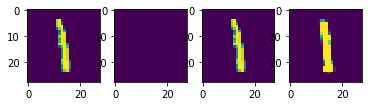

L2_distance: 14.365789413452148  Model_fooled : False  d<=theta True


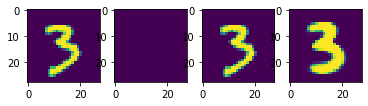

L2_distance: 48.18772506713867  Model_fooled : False  d<=theta True


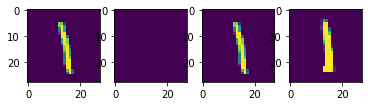


















  0%|          | 0/313 [00:00<?, ?it/s]

L2_distance: 12.706476211547852  Model_fooled : False  d<=theta True
THE ADVERSARY IS : PGD


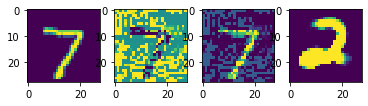

L2_distance: 148.7766876220703  Model_fooled : True  d<=theta False


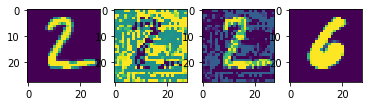

L2_distance: 117.74664306640625  Model_fooled : True  d<=theta False


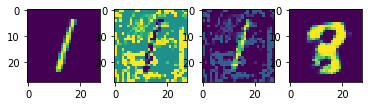

L2_distance: 118.1827392578125  Model_fooled : True  d<=theta False


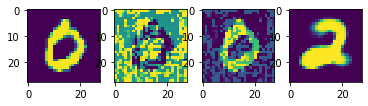

L2_distance: 117.67316436767578  Model_fooled : True  d<=theta False


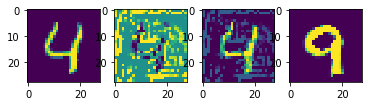

L2_distance: 74.98204803466797  Model_fooled : True  d<=theta True


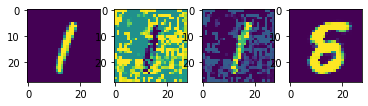

L2_distance: 131.618408203125  Model_fooled : True  d<=theta False


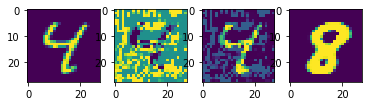

L2_distance: 126.47771453857422  Model_fooled : True  d<=theta False


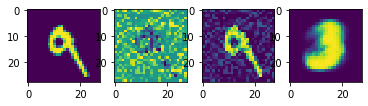

L2_distance: 106.05754089355469  Model_fooled : True  d<=theta False


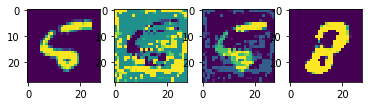

L2_distance: 114.43206787109375  Model_fooled : True  d<=theta False


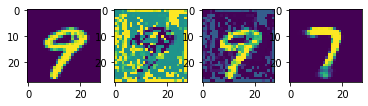

L2_distance: 89.95121002197266  Model_fooled : True  d<=theta True


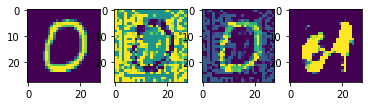

L2_distance: 125.57089233398438  Model_fooled : True  d<=theta False


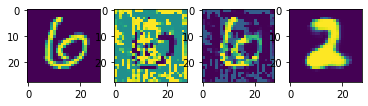

L2_distance: 92.98149108886719  Model_fooled : True  d<=theta True


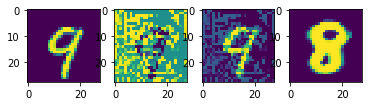

L2_distance: 114.17887878417969  Model_fooled : True  d<=theta False


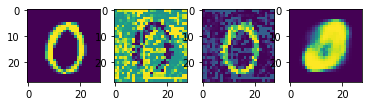

L2_distance: 117.48260498046875  Model_fooled : False  d<=theta False


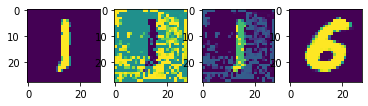

L2_distance: 135.40199279785156  Model_fooled : True  d<=theta False


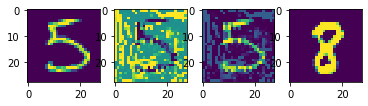

L2_distance: 124.61595153808594  Model_fooled : True  d<=theta False


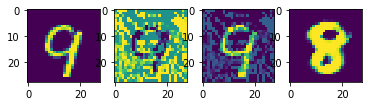

L2_distance: 113.97954559326172  Model_fooled : True  d<=theta False


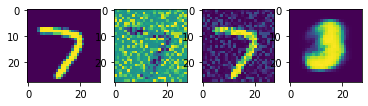

L2_distance: 103.50526428222656  Model_fooled : True  d<=theta False


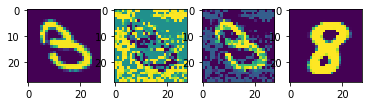

L2_distance: 179.06243896484375  Model_fooled : True  d<=theta False


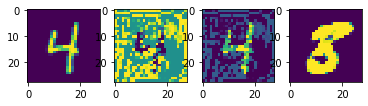

L2_distance: 124.99627685546875  Model_fooled : True  d<=theta False


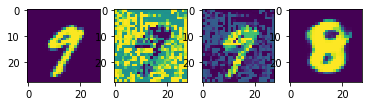

L2_distance: 118.99842071533203  Model_fooled : True  d<=theta False


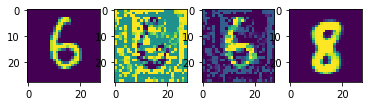

L2_distance: 95.31462097167969  Model_fooled : True  d<=theta False


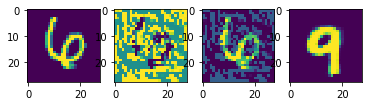

L2_distance: 99.32522583007812  Model_fooled : True  d<=theta False


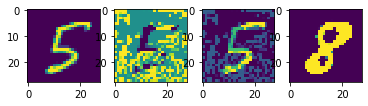

L2_distance: 104.97329711914062  Model_fooled : True  d<=theta False


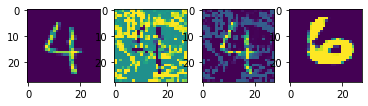

L2_distance: 126.07620239257812  Model_fooled : True  d<=theta False


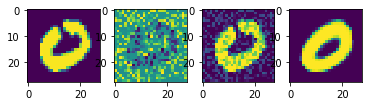

L2_distance: 54.29270935058594  Model_fooled : False  d<=theta True


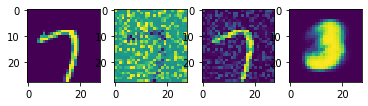

L2_distance: 112.7621841430664  Model_fooled : True  d<=theta False


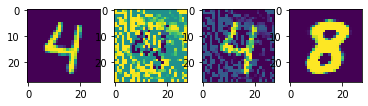

L2_distance: 118.36796569824219  Model_fooled : True  d<=theta False


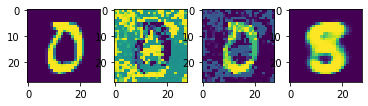

L2_distance: 86.64998626708984  Model_fooled : True  d<=theta True


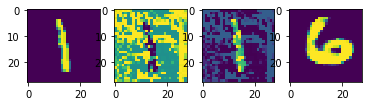

L2_distance: 134.16162109375  Model_fooled : True  d<=theta False


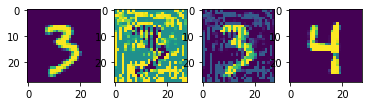

L2_distance: 101.14585876464844  Model_fooled : True  d<=theta False


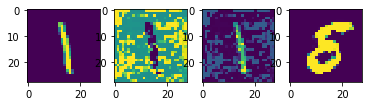



















  0%|          | 0/313 [00:00<?, ?it/s]

L2_distance: 119.15413665771484  Model_fooled : True  d<=theta False
THE ADVERSARY IS : FGSM


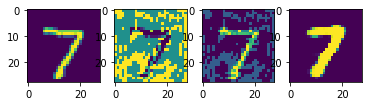

L2_distance: 78.1893081665039  Model_fooled : False  d<=theta True


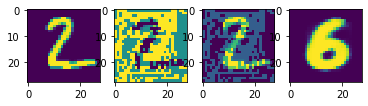

L2_distance: 118.55017852783203  Model_fooled : True  d<=theta False


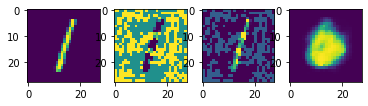

L2_distance: 100.5314712524414  Model_fooled : True  d<=theta False


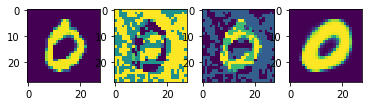

L2_distance: 86.40894317626953  Model_fooled : False  d<=theta True


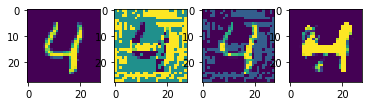

L2_distance: 108.6868896484375  Model_fooled : False  d<=theta False


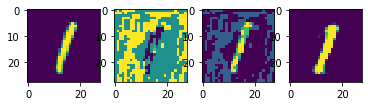

L2_distance: 37.57312774658203  Model_fooled : False  d<=theta True


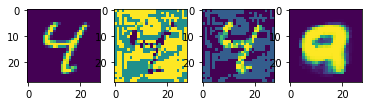

L2_distance: 136.31764221191406  Model_fooled : True  d<=theta False


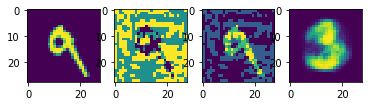

L2_distance: 88.06645202636719  Model_fooled : True  d<=theta True


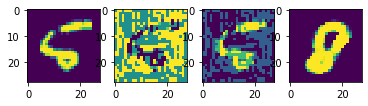

L2_distance: 124.00922393798828  Model_fooled : True  d<=theta False


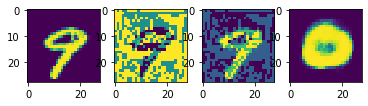

L2_distance: 122.39958190917969  Model_fooled : True  d<=theta False


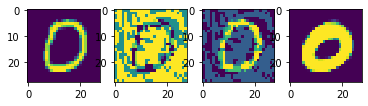

L2_distance: 115.32128143310547  Model_fooled : False  d<=theta False


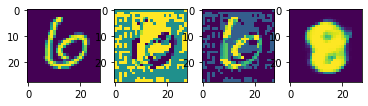

L2_distance: 109.54037475585938  Model_fooled : True  d<=theta False


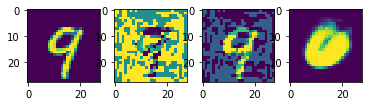

L2_distance: 106.58783721923828  Model_fooled : True  d<=theta False


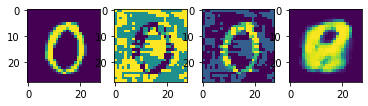

L2_distance: 111.70925903320312  Model_fooled : True  d<=theta False


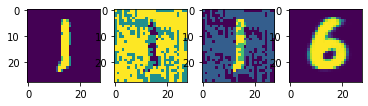

L2_distance: 108.09739685058594  Model_fooled : True  d<=theta False


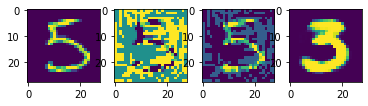

L2_distance: 106.58822631835938  Model_fooled : True  d<=theta False


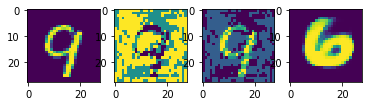

L2_distance: 122.27175903320312  Model_fooled : True  d<=theta False


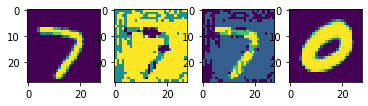

L2_distance: 133.32745361328125  Model_fooled : True  d<=theta False


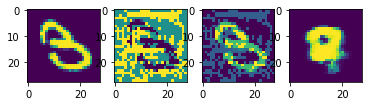

L2_distance: 115.0507583618164  Model_fooled : True  d<=theta False


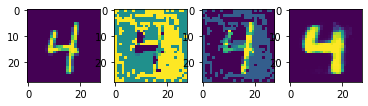

L2_distance: 76.7608413696289  Model_fooled : False  d<=theta True


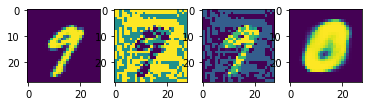

L2_distance: 111.18687438964844  Model_fooled : True  d<=theta False


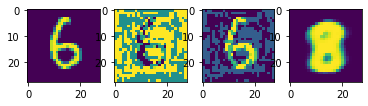

L2_distance: 104.69548034667969  Model_fooled : True  d<=theta False


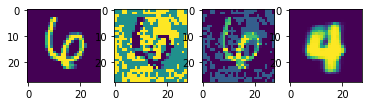

L2_distance: 88.62783813476562  Model_fooled : True  d<=theta True


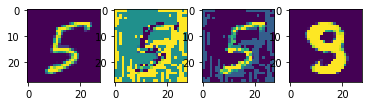

L2_distance: 125.70672607421875  Model_fooled : True  d<=theta False


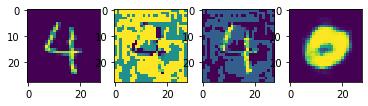

L2_distance: 124.20408630371094  Model_fooled : True  d<=theta False


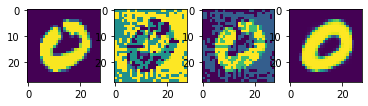

L2_distance: 64.14202880859375  Model_fooled : False  d<=theta True


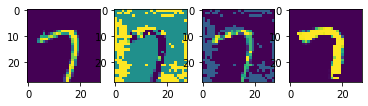

L2_distance: 61.63488006591797  Model_fooled : False  d<=theta True


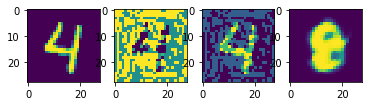

L2_distance: 97.70011138916016  Model_fooled : True  d<=theta False


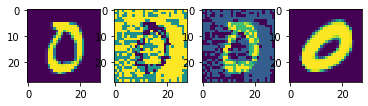

L2_distance: 112.82435607910156  Model_fooled : False  d<=theta False


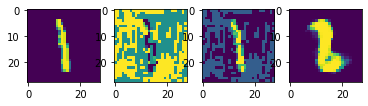

L2_distance: 79.55862426757812  Model_fooled : True  d<=theta True


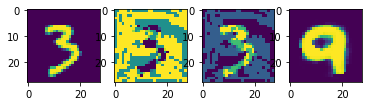

L2_distance: 129.12921142578125  Model_fooled : True  d<=theta False


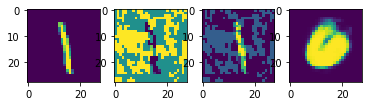




















  0%|          | 0/313 [00:00<?, ?it/s]

L2_distance: 126.72367858886719  Model_fooled : True  d<=theta False
THE ADVERSARY IS : BIM


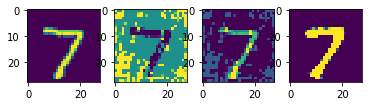

L2_distance: 61.3421630859375  Model_fooled : False  d<=theta True


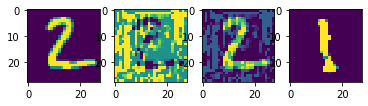

L2_distance: 103.0417251586914  Model_fooled : True  d<=theta False


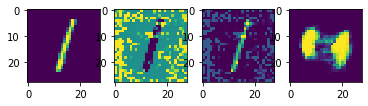

L2_distance: 128.84130859375  Model_fooled : True  d<=theta False


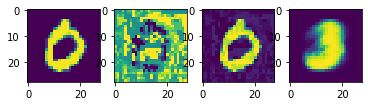

L2_distance: 67.85258483886719  Model_fooled : True  d<=theta True


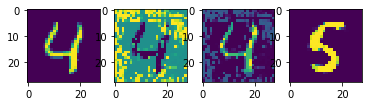

L2_distance: 102.6275634765625  Model_fooled : True  d<=theta False


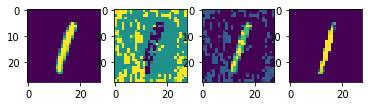

L2_distance: 28.055896759033203  Model_fooled : False  d<=theta True


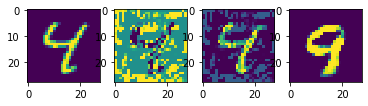

L2_distance: 98.45458984375  Model_fooled : True  d<=theta False


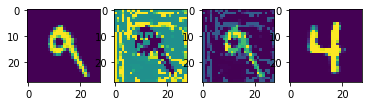

L2_distance: 80.88035583496094  Model_fooled : True  d<=theta True


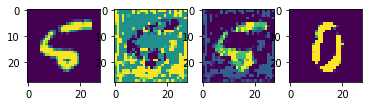

L2_distance: 106.99766540527344  Model_fooled : True  d<=theta False


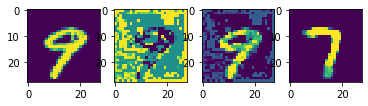

L2_distance: 103.08819580078125  Model_fooled : True  d<=theta False


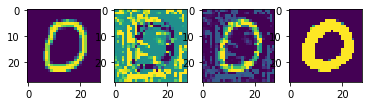

L2_distance: 104.22100830078125  Model_fooled : False  d<=theta False


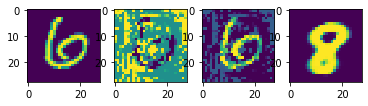

L2_distance: 136.77980041503906  Model_fooled : True  d<=theta False


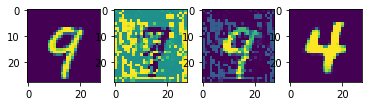

L2_distance: 72.65859985351562  Model_fooled : True  d<=theta True


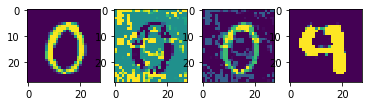

L2_distance: 134.27796936035156  Model_fooled : True  d<=theta False


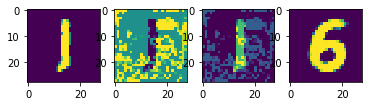

L2_distance: 128.75271606445312  Model_fooled : True  d<=theta False


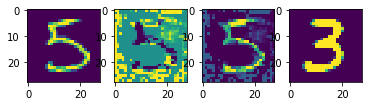

L2_distance: 108.95099639892578  Model_fooled : True  d<=theta False


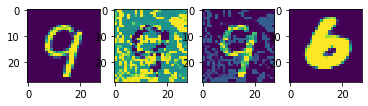

L2_distance: 146.91552734375  Model_fooled : True  d<=theta False


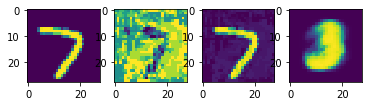

L2_distance: 102.35923767089844  Model_fooled : True  d<=theta False


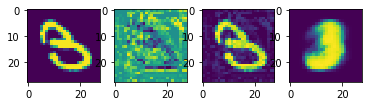

L2_distance: 117.1175765991211  Model_fooled : True  d<=theta False


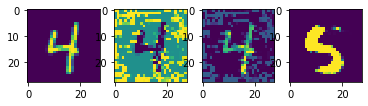

L2_distance: 91.62068939208984  Model_fooled : True  d<=theta True


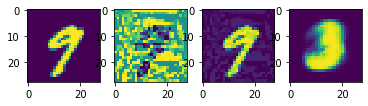

L2_distance: 78.839599609375  Model_fooled : True  d<=theta True


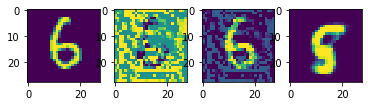

L2_distance: 97.46600341796875  Model_fooled : True  d<=theta False


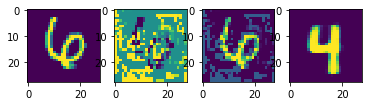

L2_distance: 94.90660858154297  Model_fooled : True  d<=theta True


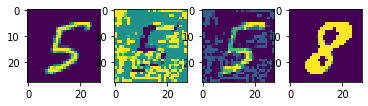

L2_distance: 104.42675018310547  Model_fooled : True  d<=theta False


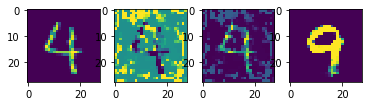

L2_distance: 77.99452209472656  Model_fooled : True  d<=theta True


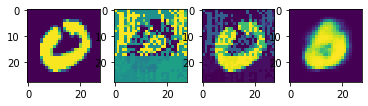

L2_distance: 80.24755859375  Model_fooled : True  d<=theta True


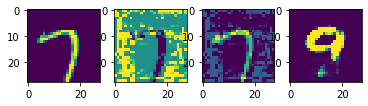

L2_distance: 84.51172637939453  Model_fooled : True  d<=theta True


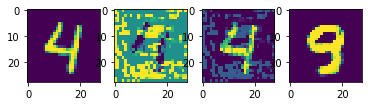

L2_distance: 70.36087036132812  Model_fooled : True  d<=theta True


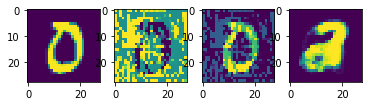

L2_distance: 105.25125885009766  Model_fooled : True  d<=theta False


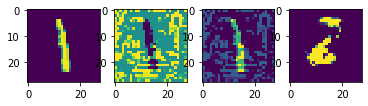

L2_distance: 87.86587524414062  Model_fooled : True  d<=theta True


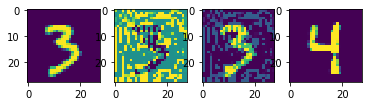

L2_distance: 107.49748992919922  Model_fooled : True  d<=theta False


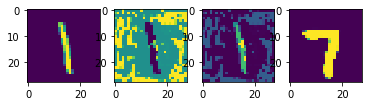

L2_distance: 92.84467315673828  Model_fooled : True  d<=theta True


In [18]:
from advertorch.attacks.base import Attack, LabelMixin
from advertorch.utils import clamp

class CleanAttack(Attack, LabelMixin):
    def __init__(self, clip_min=0., clip_max=1.):
        super(CleanAttack, self).__init__(None,None,clip_min, clip_max)

    def perturb(self, x, y=None):
#         xadv = x.requires_grad_()
#         xadv = clamp(xadv, self.clip_min, self.clip_max)
#         return xadv.detach()
        return x
    
model_for_adversary = Model_for_Adversary(net)
    
linf_eps = 0.3
fgsm_step = 0.05
bim_pgd_step = 0.01

adversary_dict = {}
adversary_dict['Clean'] = CleanAttack(clip_min=-0.4242, clip_max=2.8215)
adversary_dict['PGD'] = LinfPGDAttack(
    model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(linf_eps/0.3081),
    nb_iter=1000, eps_iter=(bim_pgd_step/0.3081), rand_init=True, clip_min=-0.4242, clip_max=2.8215,
    targeted=False)

adversary_dict['FGSM'] = GradientSignAttack(model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(linf_eps/0.3081), clip_min=-0.4242, clip_max=2.8215, targeted=False)
adversary_dict['BIM'] = LinfBasicIterativeAttack(model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(linf_eps/0.3081), nb_iter=1000, eps_iter=(bim_pgd_step/0.3081), clip_min=-0.4242, clip_max=2.8215, targeted=False)
# adversary_dict['CW'] = CarliniWagnerL2Attack(model_for_adversary, num_classes=args['num_classes'], confidence=0, targeted=False, learning_rate=0.01, binary_search_steps=9, max_iterations=1000, abort_early=True, initial_const=0.001, clip_min=-0.4242, clip_max=2.8215, loss_fn=None)

WhiteBox_Attacks_Untargeted(net, testloader, adversary_dict, args, 95)





















  0%|          | 0/313 [00:00<?, ?it/s]

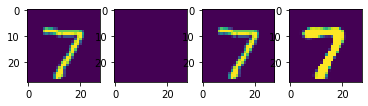

L2_distance: 30.05651092529297 Target:  9 Model_fooled : False : d <= theta True


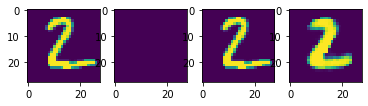

L2_distance: 42.75883865356445 Target:  7 Model_fooled : False : d <= theta True


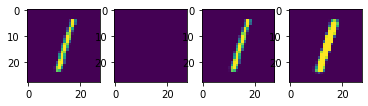

L2_distance: 12.031614303588867 Target:  7 Model_fooled : False : d <= theta True


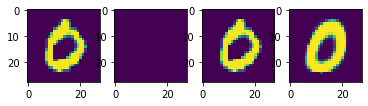

L2_distance: 35.9091796875 Target:  2 Model_fooled : False : d <= theta True


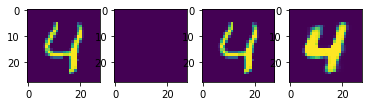

L2_distance: 48.96803283691406 Target:  2 Model_fooled : False : d <= theta True


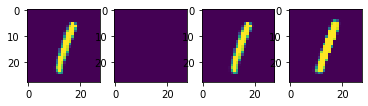

L2_distance: 5.340488433837891 Target:  4 Model_fooled : False : d <= theta True


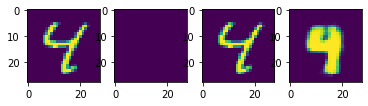

L2_distance: 76.41002655029297 Target:  5 Model_fooled : False : d <= theta True


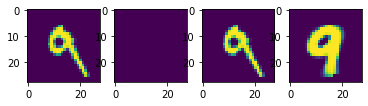

L2_distance: 83.83529663085938 Target:  1 Model_fooled : False : d <= theta True


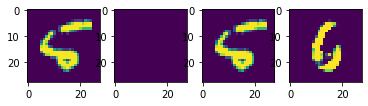

L2_distance: 91.19009399414062 Target:  2 Model_fooled : False : d <= theta True


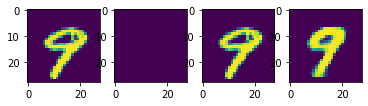

L2_distance: 23.73257064819336 Target:  6 Model_fooled : False : d <= theta True


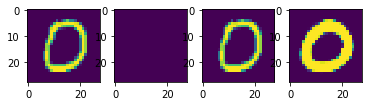

L2_distance: 72.02308654785156 Target:  9 Model_fooled : False : d <= theta True


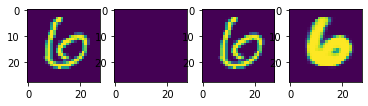

L2_distance: 84.99049377441406 Target:  8 Model_fooled : False : d <= theta True


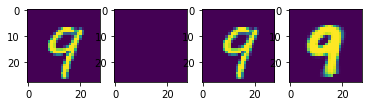

L2_distance: 45.257877349853516 Target:  9 Model_fooled : True : d <= theta True


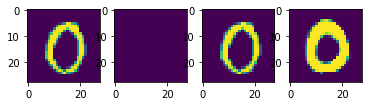

L2_distance: 57.76347351074219 Target:  5 Model_fooled : False : d <= theta True


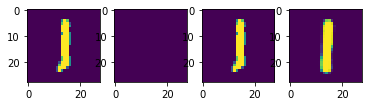

L2_distance: 10.316215515136719 Target:  9 Model_fooled : False : d <= theta True


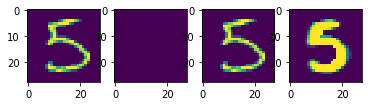

L2_distance: 74.70440673828125 Target:  5 Model_fooled : True : d <= theta True


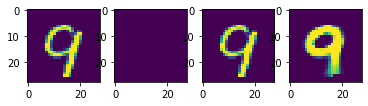

L2_distance: 41.07187271118164 Target:  5 Model_fooled : False : d <= theta True


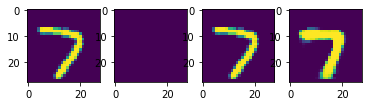

L2_distance: 48.49518966674805 Target:  0 Model_fooled : False : d <= theta True


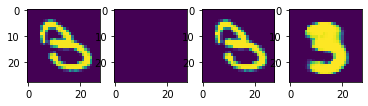

L2_distance: 119.19453430175781 Target:  4 Model_fooled : False : d <= theta False


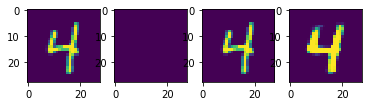

L2_distance: 28.619976043701172 Target:  8 Model_fooled : False : d <= theta True


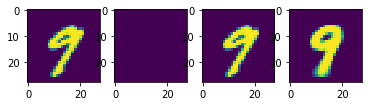

L2_distance: 28.41575813293457 Target:  7 Model_fooled : False : d <= theta True


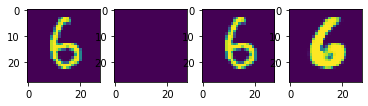

L2_distance: 64.59111022949219 Target:  2 Model_fooled : False : d <= theta True


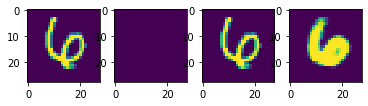

L2_distance: 76.18659973144531 Target:  2 Model_fooled : False : d <= theta True


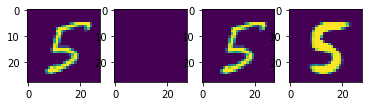

L2_distance: 54.05396270751953 Target:  4 Model_fooled : False : d <= theta True


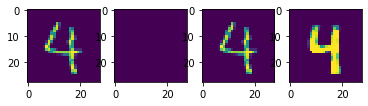

L2_distance: 40.288787841796875 Target:  0 Model_fooled : False : d <= theta True


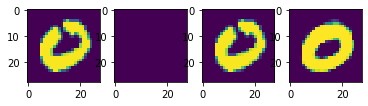

L2_distance: 48.50832748413086 Target:  0 Model_fooled : True : d <= theta True


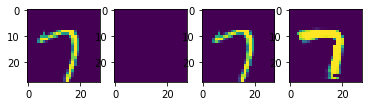

L2_distance: 39.95034408569336 Target:  8 Model_fooled : False : d <= theta True


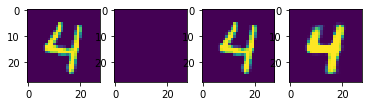

L2_distance: 28.154556274414062 Target:  0 Model_fooled : False : d <= theta True


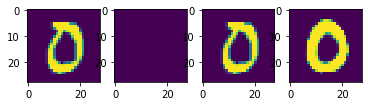

L2_distance: 41.447532653808594 Target:  7 Model_fooled : False : d <= theta True


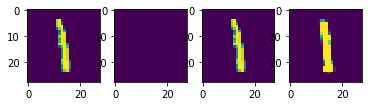

L2_distance: 14.365789413452148 Target:  6 Model_fooled : False : d <= theta True


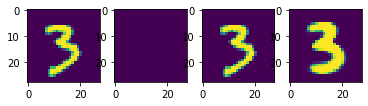

L2_distance: 48.18772506713867 Target:  0 Model_fooled : False : d <= theta True


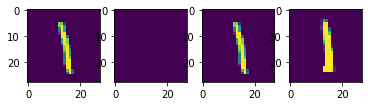






















  0%|          | 0/313 [00:00<?, ?it/s]

L2_distance: 12.706476211547852 Target:  3 Model_fooled : False : d <= theta True


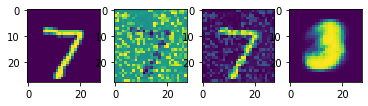

L2_distance: 107.16310119628906 Target:  4 Model_fooled : False : d <= theta False


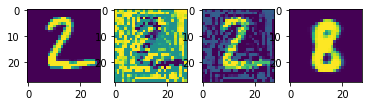

L2_distance: 105.07058715820312 Target:  8 Model_fooled : True : d <= theta False


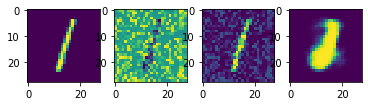

L2_distance: 69.83880615234375 Target:  0 Model_fooled : False : d <= theta True


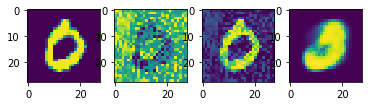

L2_distance: 77.06103515625 Target:  8 Model_fooled : False : d <= theta True


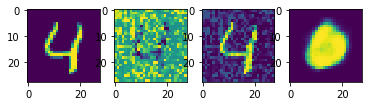

L2_distance: 120.52188873291016 Target:  5 Model_fooled : False : d <= theta False


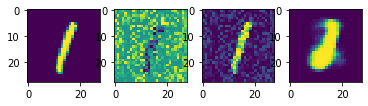

L2_distance: 59.42639923095703 Target:  0 Model_fooled : False : d <= theta True


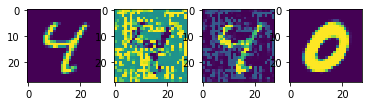

L2_distance: 166.00584411621094 Target:  0 Model_fooled : True : d <= theta False


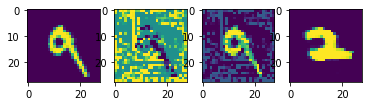

L2_distance: 74.37763977050781 Target:  2 Model_fooled : True : d <= theta True


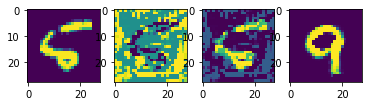

L2_distance: 105.80686950683594 Target:  9 Model_fooled : True : d <= theta False


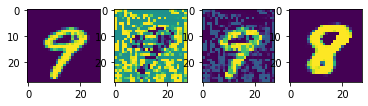

L2_distance: 95.3695068359375 Target:  8 Model_fooled : True : d <= theta False


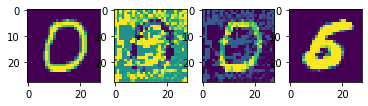

L2_distance: 132.93922424316406 Target:  5 Model_fooled : True : d <= theta False


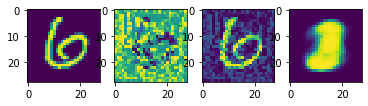

L2_distance: 114.80070495605469 Target:  3 Model_fooled : False : d <= theta False


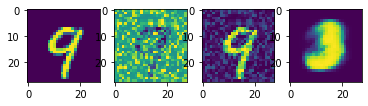

L2_distance: 96.3493881225586 Target:  1 Model_fooled : True : d <= theta False


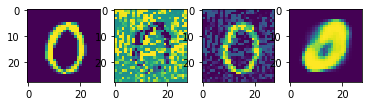

L2_distance: 119.16738891601562 Target:  1 Model_fooled : False : d <= theta False


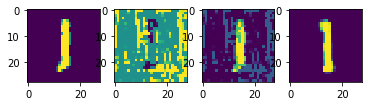

L2_distance: 28.381580352783203 Target:  1 Model_fooled : True : d <= theta True


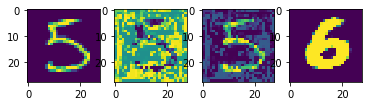

L2_distance: 150.1287078857422 Target:  6 Model_fooled : True : d <= theta False


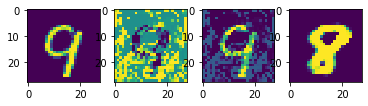

L2_distance: 117.18829345703125 Target:  8 Model_fooled : True : d <= theta False


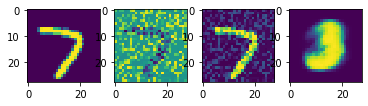

L2_distance: 107.02455139160156 Target:  3 Model_fooled : False : d <= theta False


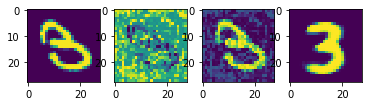

L2_distance: 127.98252868652344 Target:  3 Model_fooled : True : d <= theta False


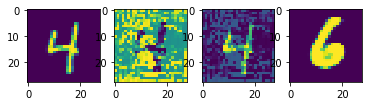

L2_distance: 99.9816665649414 Target:  6 Model_fooled : True : d <= theta False


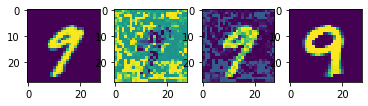

L2_distance: 125.06871032714844 Target:  9 Model_fooled : True : d <= theta False


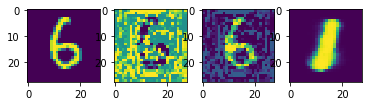

L2_distance: 102.4283218383789 Target:  1 Model_fooled : True : d <= theta False


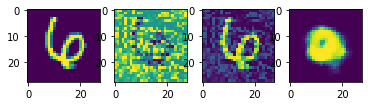

L2_distance: 81.03297424316406 Target:  7 Model_fooled : False : d <= theta True


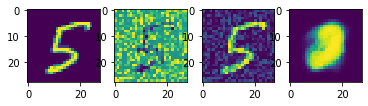

L2_distance: 99.23847961425781 Target:  2 Model_fooled : True : d <= theta False


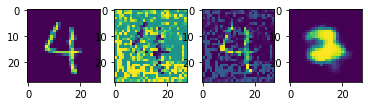

L2_distance: 78.57911682128906 Target:  3 Model_fooled : False : d <= theta True


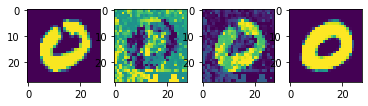

L2_distance: 50.82151794433594 Target:  0 Model_fooled : True : d <= theta True


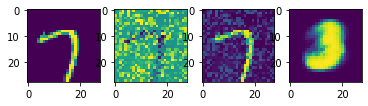

L2_distance: 111.17923736572266 Target:  8 Model_fooled : False : d <= theta False


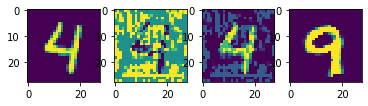

L2_distance: 72.83501434326172 Target:  9 Model_fooled : True : d <= theta True


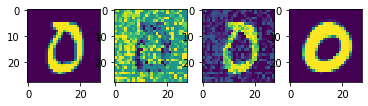

L2_distance: 77.39021301269531 Target:  0 Model_fooled : True : d <= theta True


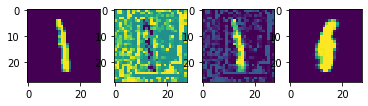

L2_distance: 65.57373809814453 Target:  4 Model_fooled : True : d <= theta True


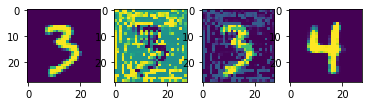

L2_distance: 108.98602294921875 Target:  4 Model_fooled : True : d <= theta False


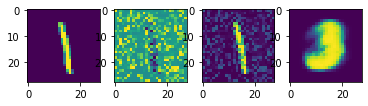























  0%|          | 0/313 [00:00<?, ?it/s]

L2_distance: 104.73384094238281 Target:  2 Model_fooled : False : d <= theta False


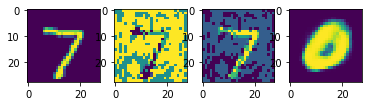

L2_distance: 127.56462860107422 Target:  0 Model_fooled : True : d <= theta False


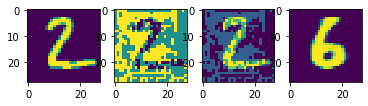

L2_distance: 90.7942886352539 Target:  4 Model_fooled : False : d <= theta True


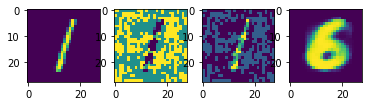

L2_distance: 130.71914672851562 Target:  3 Model_fooled : False : d <= theta False


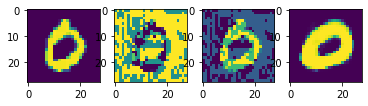

L2_distance: 96.2843017578125 Target:  3 Model_fooled : False : d <= theta False


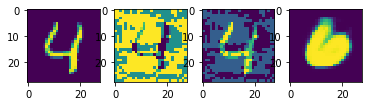

L2_distance: 115.19429779052734 Target:  3 Model_fooled : False : d <= theta False


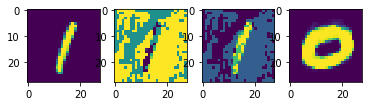

L2_distance: 161.79061889648438 Target:  8 Model_fooled : False : d <= theta False


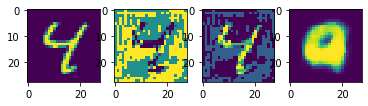

L2_distance: 134.11788940429688 Target:  0 Model_fooled : False : d <= theta False


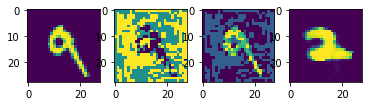

L2_distance: 82.5248031616211 Target:  2 Model_fooled : True : d <= theta True


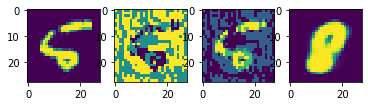

L2_distance: 130.77197265625 Target:  3 Model_fooled : False : d <= theta False


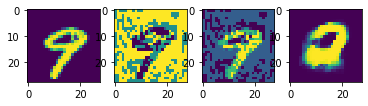

L2_distance: 106.8670883178711 Target:  2 Model_fooled : False : d <= theta False


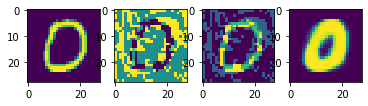

L2_distance: 118.6629867553711 Target:  0 Model_fooled : True : d <= theta False


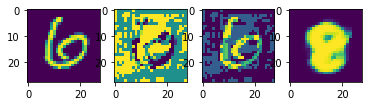

L2_distance: 113.22850036621094 Target:  3 Model_fooled : False : d <= theta False


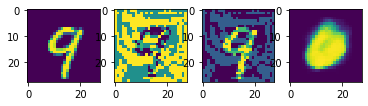

L2_distance: 99.77812194824219 Target:  2 Model_fooled : False : d <= theta False


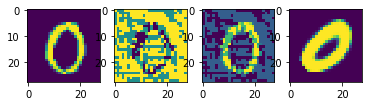

L2_distance: 124.54588317871094 Target:  6 Model_fooled : False : d <= theta False


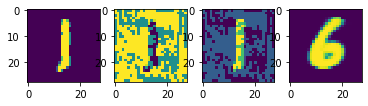

L2_distance: 95.5720443725586 Target:  9 Model_fooled : False : d <= theta False


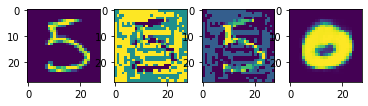

L2_distance: 170.08523559570312 Target:  3 Model_fooled : False : d <= theta False


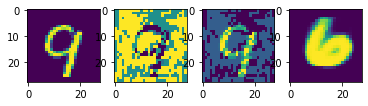

L2_distance: 114.48316955566406 Target:  8 Model_fooled : False : d <= theta False


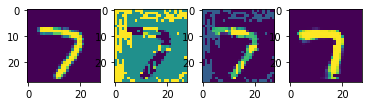

L2_distance: 71.95134735107422 Target:  7 Model_fooled : True : d <= theta True


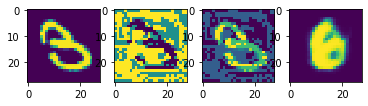

L2_distance: 110.08760070800781 Target:  2 Model_fooled : False : d <= theta False


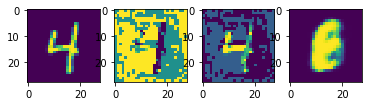

L2_distance: 99.91129302978516 Target:  4 Model_fooled : False : d <= theta False


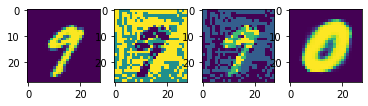

L2_distance: 117.43244934082031 Target:  5 Model_fooled : False : d <= theta False


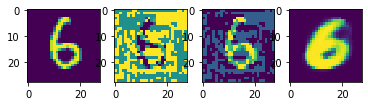

L2_distance: 98.71116638183594 Target:  7 Model_fooled : False : d <= theta False


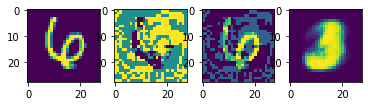

L2_distance: 97.51148986816406 Target:  5 Model_fooled : False : d <= theta False


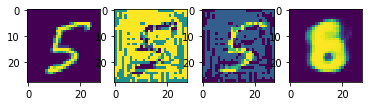

L2_distance: 121.31704711914062 Target:  9 Model_fooled : False : d <= theta False


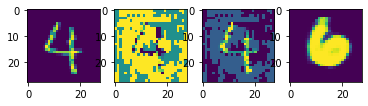

L2_distance: 117.3365707397461 Target:  0 Model_fooled : False : d <= theta False


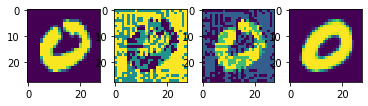

L2_distance: 66.07344818115234 Target:  9 Model_fooled : False : d <= theta True


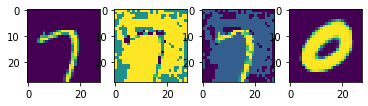

L2_distance: 139.97775268554688 Target:  2 Model_fooled : False : d <= theta False


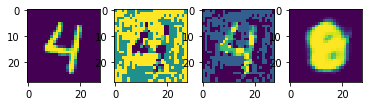

L2_distance: 113.74627685546875 Target:  2 Model_fooled : False : d <= theta False


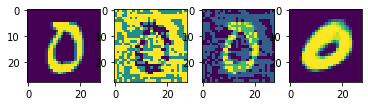

L2_distance: 110.22343444824219 Target:  3 Model_fooled : False : d <= theta False


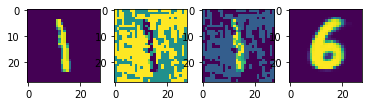

L2_distance: 97.45291137695312 Target:  9 Model_fooled : False : d <= theta False


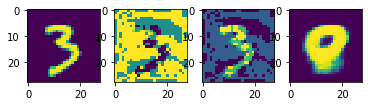

L2_distance: 124.64602661132812 Target:  0 Model_fooled : False : d <= theta False


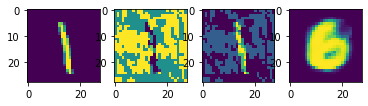
























  0%|          | 0/313 [00:00<?, ?it/s]

L2_distance: 132.99057006835938 Target:  6 Model_fooled : True : d <= theta False


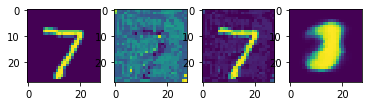

L2_distance: 90.67349243164062 Target:  1 Model_fooled : True : d <= theta True


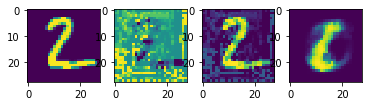

L2_distance: 55.87777328491211 Target:  5 Model_fooled : True : d <= theta True


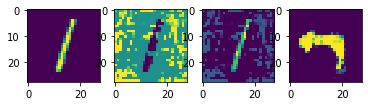

L2_distance: 105.79168701171875 Target:  5 Model_fooled : True : d <= theta False


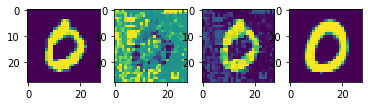

L2_distance: 58.631797790527344 Target:  0 Model_fooled : True : d <= theta True


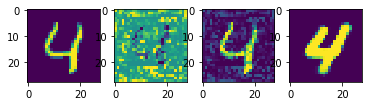

L2_distance: 93.47639465332031 Target:  4 Model_fooled : True : d <= theta True


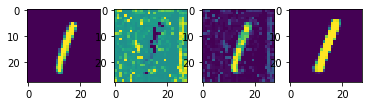

L2_distance: 19.983736038208008 Target:  1 Model_fooled : True : d <= theta True


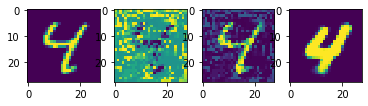

L2_distance: 104.48991394042969 Target:  4 Model_fooled : True : d <= theta False


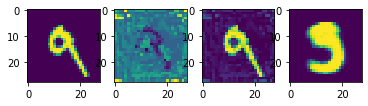

L2_distance: 105.91796875 Target:  5 Model_fooled : False : d <= theta False


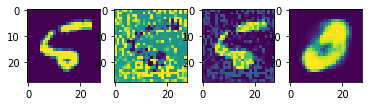

L2_distance: 114.21109008789062 Target:  1 Model_fooled : True : d <= theta False


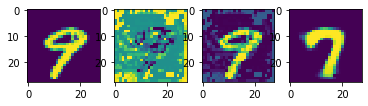

L2_distance: 91.97474670410156 Target:  7 Model_fooled : True : d <= theta True


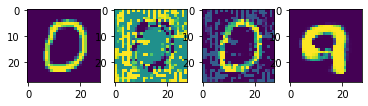

L2_distance: 147.80352783203125 Target:  9 Model_fooled : True : d <= theta False


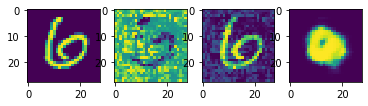

L2_distance: 91.25665283203125 Target:  7 Model_fooled : False : d <= theta True


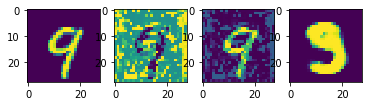

L2_distance: 138.498291015625 Target:  3 Model_fooled : True : d <= theta False


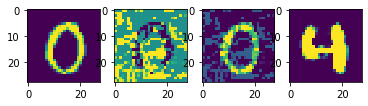

L2_distance: 124.50141906738281 Target:  4 Model_fooled : True : d <= theta False


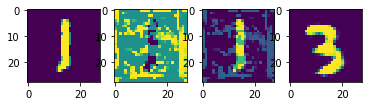

L2_distance: 88.63677978515625 Target:  3 Model_fooled : True : d <= theta True


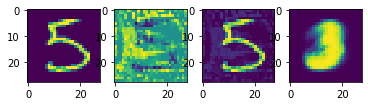

L2_distance: 129.2352294921875 Target:  2 Model_fooled : False : d <= theta False


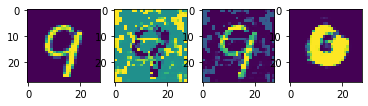

L2_distance: 97.8994140625 Target:  0 Model_fooled : True : d <= theta False


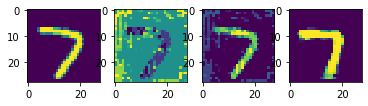

L2_distance: 58.05403137207031 Target:  7 Model_fooled : True : d <= theta True


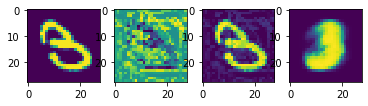

L2_distance: 117.03028106689453 Target:  7 Model_fooled : False : d <= theta False


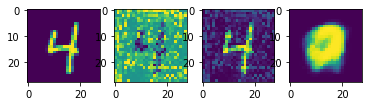

L2_distance: 106.35205078125 Target:  7 Model_fooled : False : d <= theta False


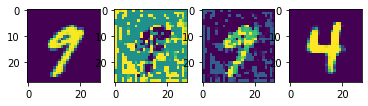

L2_distance: 92.94734954833984 Target:  4 Model_fooled : True : d <= theta True


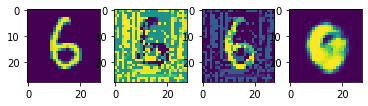

L2_distance: 90.99080657958984 Target:  9 Model_fooled : True : d <= theta True


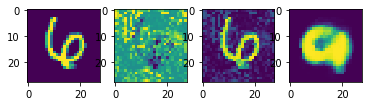

L2_distance: 98.96157836914062 Target:  7 Model_fooled : False : d <= theta False


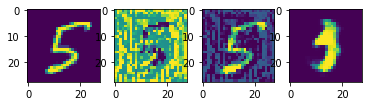

L2_distance: 88.07630920410156 Target:  7 Model_fooled : True : d <= theta True


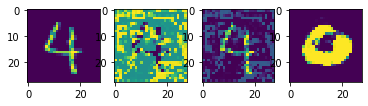

L2_distance: 141.5697479248047 Target:  0 Model_fooled : True : d <= theta False


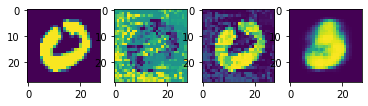

L2_distance: 88.68624877929688 Target:  7 Model_fooled : False : d <= theta True


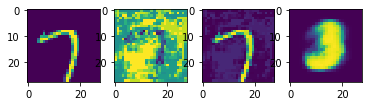

L2_distance: 110.12315368652344 Target:  6 Model_fooled : False : d <= theta False


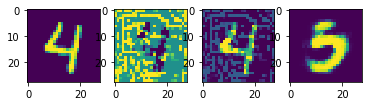

L2_distance: 109.96604919433594 Target:  5 Model_fooled : True : d <= theta False


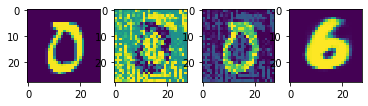

L2_distance: 95.96292114257812 Target:  6 Model_fooled : True : d <= theta False


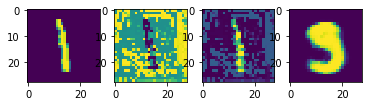

L2_distance: 140.32461547851562 Target:  3 Model_fooled : True : d <= theta False


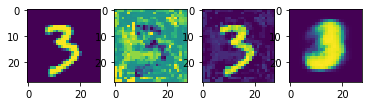

L2_distance: 79.89849853515625 Target:  0 Model_fooled : False : d <= theta True


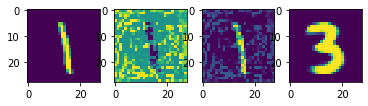

L2_distance: 100.97345733642578 Target:  3 Model_fooled : True : d <= theta False


In [19]:
model_for_adversary = Model_for_Adversary(net)
    
linf_eps = 0.3
fgsm_step = 0.05
bim_pgd_step = 0.01

adversary_dict = {}
adversary_dict['Clean'] = CleanAttack(clip_min=-0.4242, clip_max=2.8215)
adversary_dict['PGD'] = LinfPGDAttack(
    model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(linf_eps/0.3081),
    nb_iter=1000, eps_iter=(bim_pgd_step/0.3081), rand_init=True, clip_min=-0.4242, clip_max=2.8215,
    targeted=True)

adversary_dict['FGSM'] = GradientSignAttack(model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(linf_eps/0.3081), clip_min=-0.4242, clip_max=2.8215, targeted=True)
adversary_dict['BIM'] = LinfBasicIterativeAttack(model_for_adversary, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=(linf_eps/0.3081), nb_iter=1000, eps_iter=(bim_pgd_step/0.3081), clip_min=-0.4242, clip_max=2.8215, targeted=True)
# adversary_dict['CW'] = CarliniWagnerL2Attack(model_for_adversary, num_classes=args['num_classes'], confidence=0, targeted=False, learning_rate=0.01, binary_search_steps=9, max_iterations=1000, abort_early=True, initial_const=0.001, clip_min=-0.4242, clip_max=2.8215, loss_fn=None)

WhiteBox_Attacks_Targeted(net, testloader, adversary_dict, args, 95)